# Imports and custom functions

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from scipy import stats
import seaborn as sns
import powerlaw
from scipy.stats import poisson
from scipy.stats import norm  
from sklearn.model_selection import train_test_split
import math
import random
from random import shuffle
from scipy.stats import gmean
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.cm as cm
from networkx.algorithms import bipartite

def get_all_indices(mylist, myval):
    
    all_indices = []
    
    for i in range(len(mylist)):
        if mylist[i] == myval:
            all_indices.append(i)
            
    return all_indices

def closest(lst, K):
    
    number = lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
    
    if abs(number-K) >= 3:
        print('Not close enough: ', int(abs(number-K)))
    
    # number_index = np.random.choice(get_all_indices(lst,number))
      
    return get_all_indices(lst,number) # number_index

def remove_zeros_distribution(x):

    return [i for i in x if i != 0]

def log_binning_distribution(x_i, B = 20): 
    
    x_i = remove_zeros_distribution(x_i)

    b_1 = min(x_i)
    b_Bp1 = max(x_i)
    q_1 = np.log(b_1)
    q_Bp1 = np.log(b_Bp1)
    D_q = q_Bp1 - q_1
    L_q = D_q / B

    q_list = []
    b_list = []

    for i in range(B):
        j = i + 1
        q_list.append(q_1 + (j-1)*L_q)
        b_list.append(np.exp(q_1 + (j-1)*L_q))
   
    binned_x_i = []
    density_list = []

    for i in range(len(b_list)-1):
        bin_low = b_list[i]
        bin_high = b_list[i+1]
        count_bin = 0
        for j in range(len(x_i)):
            if x_i[j] >= bin_low and x_i[j] < bin_high:
                count_bin = count_bin + 1
                
        if count_bin > 0:
            density_bin = count_bin / (len(x_i)*(bin_high-bin_low))
            density_list.append(density_bin)
            binned_x_i.append(bin_low)
        else:
            continue 
            
    return binned_x_i, density_list

def generate_network(G, node_Kd_values, kd_list, p_bind = 0.5):
    
    node_list_1 = []
    node_list_2 = []
    node_Kd_list_1 = []
    node_Kd_list_2 = []
    
    for edge in tqdm(list(G.edges())):
        node_list_1.append(edge[0])
        node_list_2.append(edge[1])
        node_Kd_list_1.append(node_Kd_values[edge[0]])
        node_Kd_list_2.append(node_Kd_values[edge[1]])
    
    network_data = pd.DataFrame()
    network_data['node_1'] = node_list_1
    network_data['node_2'] = node_list_2
    network_data['node_1_Kd'] = node_Kd_list_1
    network_data['node_2_Kd'] = node_Kd_list_2
    network_data['edge_Kd'] = [np.sqrt(a*b) for a,b in zip(node_Kd_list_1,node_Kd_list_2)]

    figure(figsize=(8, 8))
    ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), label='BindingDB', norm_hist=True)
    ax = sns.distplot(np.log10(list(node_Kd_values.values())), label='Generated network Nodes', norm_hist=True)
    ax = sns.distplot(np.log10(network_data['edge_Kd']), label='Generated network Edges', norm_hist=True)
    ax.set(xlabel='log Kd', ylabel='pdf')
    plt.legend()
    plt.show()

    ## Making binary labels with p_bind

    Kd_for_edges = network_data['edge_Kd'].tolist()
    threshold = np.exp(norm.ppf(p_bind, loc=np.mean(np.log(Kd_for_edges)), scale=np.std(np.log(Kd_for_edges))))

    print('Threshold: ', threshold) ## in nM

    binary_labels = [1 if x < threshold else 0 for x in Kd_for_edges]

    network_data['binary_label'] = binary_labels
    
    return network_data

# unipartite positive and negative layers ...k01, k10 are column vectors
def multidegree_entropy_pos_neg(k01, k10, precision=10**(-5), loops=10000):
    n=len(k01)
    t01=np.random.uniform(size=(n,1))
    t10=np.random.uniform(size=(n,1))
    oldt01=np.random.uniform(size=(n,1))
    oldt10=np.random.uniform(size=(n,1))    
    
    for kk in tqdm(range(loops)):
            T01=t01*(t01.transpose())
            T10=t10*(t10.transpose())
            Z=1+ T01 + T10
            
            #p01
            summat=(np.ones((n,1))*t01.transpose())/(Z+(Z==0))
            summat=summat-np.diag(np.diagonal(summat))
            summat=np.sum(summat,axis=1, keepdims=True);
            t01=k01/(summat+(summat==0))
            T01=t01*(t01.transpose())
            
            Z=1+ T01 + T10
    
            #p10
            summat=(np.ones((n,1))*t10.transpose())/(Z+(Z==0))
            summat=summat-np.diag(np.diagonal(summat))
            summat=np.sum(summat,axis=1,keepdims=True)
            t10=k10/(summat+(summat==0))
            
            #print((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))))
            
            #print(max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0))))))
            
            if np.logical_and((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))< precision),(max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0)))))<precision)):
                break

            oldt01=t01
            oldt10=t10
            
            
    print("Loops ", kk+1)
    print('Error margin: ', max((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))),max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0)))))))
    T01=t01*(t01.transpose());
    T10=t10*(t10.transpose());

    Z=1+ T01 + T10;
    
    
    summat01=T01/(Z+(Z==0))
    summat01=summat01-np.diag(np.diagonal(summat01))
    k01cal=np.sum(summat01,axis=1,keepdims=True);  
    
    summat10=T10/(Z+(Z==0))
    summat10=summat10-np.diag(np.diagonal(summat10))
    k10cal=np.sum(summat10,axis=1,keepdims=True)
                    
    pconditional=summat10/(summat10+summat01+(summat10==0))
    
    return (summat01, k01cal, summat10, k10cal, pconditional)   

    return network_data

def run_configuration_model(network_data, precision=10**(-5), loops=10000):

    ## Create train-test split

    train, test = train_test_split(network_data, test_size=0.3)

    train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
    train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

    degree_train_1_0 = []
    degree_train_0_1 = []

    for node in tqdm(train_nodes):
        sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
        degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
        degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
    ## Degree ratio distirbution

    degree_ratio_list = [degree_train_1_0[i]/(degree_train_1_0[i] + degree_train_0_1[i]) for i in range(len(train_nodes))]

    figure(figsize=(8, 8))
    ax = sns.distplot(degree_ratio_list, norm_hist=True, hist_kws=dict(alpha=0.1))
    ax.set(xlim = [0,1], xlabel=r'$\rho$', ylabel='PDF')
    plt.show()

    sum_degree =  [a + b for a,b in zip(degree_train_1_0,degree_train_0_1)]
    print('Number of nodes with not positive or negative annotation: ', sum_degree.count(0))

    print('Validating p_bind value from binary labels: ', network_data['binary_label'].tolist().count(1) / len(network_data))

    summat01, k01cal, summat10, k10cal, pconditional = multidegree_entropy_pos_neg(np.array([degree_train_0_1]).T, np.array([degree_train_1_0]).T, precision=precision, loops=loops)

    test_probabilty_predicted_conditioned = []
    test_type_list = []

    ## Average conditional probability
    p10_avg = np.mean(summat10)
    p01_avg = np.mean(summat01)
    average_conditional_probability = p10_avg / (p10_avg + p01_avg)

    for index, row in tqdm(test.iterrows()):      
    
        if row['node_1'] in train_nodes and row['node_2'] in train_nodes:
            mapped_index_in_matrix_node_1 = train_nodes_index_map[row['node_1']]
            mapped_index_in_matrix_node_2 = train_nodes_index_map[row['node_2']]
            p10_conditioned = pconditional[mapped_index_in_matrix_node_1, mapped_index_in_matrix_node_2]
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Transductive')
        
        elif row['node_1'] in train_nodes and row['node_2'] not in train_nodes:
            mapped_index_in_matrix_node_1 = train_nodes_index_map[row['node_1']]
            p10_conditioned = degree_train_1_0[mapped_index_in_matrix_node_1] / (degree_train_0_1[mapped_index_in_matrix_node_1] + degree_train_1_0[mapped_index_in_matrix_node_1] ) ## k_+ / (k_+ + k_-)
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Semi-inductive')
        
        elif row['node_1'] not in train_nodes and row['node_2'] in train_nodes:
            mapped_index_in_matrix_node_2 = train_nodes_index_map[row['node_2']]
            p10_conditioned = degree_train_1_0[mapped_index_in_matrix_node_2] / (degree_train_0_1[mapped_index_in_matrix_node_2] + degree_train_1_0[mapped_index_in_matrix_node_2] ) ## k_+ / (k_+ + k_-)
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Semi-inductive')
        
        else:
            p10_conditioned = average_conditional_probability
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Inductive')
        
    test_predictions = test.copy()
    test_predictions['predicted_probability'] = test_probabilty_predicted_conditioned
    test_predictions['test_type'] = test_type_list

    ## Performance on the test dataset

    print('AUC: ', roc_auc_score(test_predictions['binary_label'].tolist(), test_predictions['predicted_probability'].tolist()))
    print('AUP: ', average_precision_score(test_predictions['binary_label'].tolist(), test_predictions['predicted_probability'].tolist()))

    print('Transductive performance:')

    test_predictions_transductive = test_predictions[test_predictions['test_type'] == 'Transductive']
    print('AUC: ', roc_auc_score(test_predictions_transductive['binary_label'].tolist(), test_predictions_transductive['predicted_probability'].tolist()))
    print('AUP: ', average_precision_score(test_predictions_transductive['binary_label'].tolist(), test_predictions_transductive['predicted_probability'].tolist()))

    figure(figsize=(8, 8))
    #ax = sns.distplot(test_predictions['predicted_probability'].tolist(), norm_hist=True, hist_kws=dict(alpha=0.1))
    ax = sns.distplot(test_predictions_transductive['predicted_probability'].tolist(), norm_hist=True, hist_kws=dict(alpha=0.1))
    ax.set(xlim = [0,1], xlabel='$p^{conditional}$', ylabel='PDF')
    plt.show()
    
    return

def sampling_with_corrP(G, corrc, mean_log_Kd, std_log_Kd, kd_list, p_bind = 0.5, iterl=5000): ## P for Poisson
    
    degrees_from_network = [G.degree(node) for node in list(G.nodes())]
    cdfk=[poisson.cdf(x, np.mean(degrees_from_network)) for x in degrees_from_network]
    MAT=np.array([degrees_from_network, cdfk, norm.ppf(cdfk, loc=0, scale=1)]).T
    expMU=mean_log_Kd+corrc*std_log_Kd*MAT[:,2]
    expSIGMA=np.sqrt((1-corrc**2)*(std_log_Kd**2))
    
    MATsample=np.zeros((len(expMU), iterl))
    for it in tqdm(range(iterl)):        
        MATsample[:,it]=np.exp(norm.rvs(loc=expMU, scale=expSIGMA))
        
    random_Kd_dict = dict()
    node_degree_list = []
    degree_Kd_list_list = []
    degree_log_Kd_list_list = []

    for node in tqdm(list(G.nodes())):
        random_Kd_dict[node] = list(MATsample[node, :])  
        node_degree_list.append(G.degree(node))
        degree_Kd_list_list.append(list(MATsample[node, :]))
        degree_log_Kd_list_list.append(list(np.log(MATsample[node, :])))
        
    different_protein_annotations = list(set(node_degree_list))
    unique_Kd_proteins = []
    unique_Kd_proteins_std = []
    unique_log_Kd_proteins = []
    unique_log_Kd_proteins_std = []

    for unique_ann in tqdm(different_protein_annotations):
    
        all_Kd_list = []   
        all_log_Kd_list = []  
        all_indices = get_all_indices(node_degree_list,unique_ann)
    
        for j in all_indices:
            all_Kd_list = all_Kd_list + degree_Kd_list_list[j]
            all_log_Kd_list = all_log_Kd_list + degree_log_Kd_list_list[j]
        
        unique_Kd_proteins.append(np.mean(all_Kd_list))
        unique_Kd_proteins_std.append(np.std(all_Kd_list))
        unique_log_Kd_proteins.append(np.mean(all_log_Kd_list))
        unique_log_Kd_proteins_std.append(np.std(all_log_Kd_list))

    figure(figsize=(8, 8))
    plt.errorbar(different_protein_annotations, unique_Kd_proteins, yerr=unique_Kd_proteins_std, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
        
    figure(figsize=(8, 8))
    plt.errorbar(different_protein_annotations, unique_log_Kd_proteins, yerr=unique_log_Kd_proteins_std, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.show()
    
    node_list_1 = []
    node_list_2 = []
    node_Kd_list_1 = []
    node_Kd_list_2 = []
    
    for edge in tqdm(list(G.edges())):
        node_list_1.append(edge[0])
        node_list_2.append(edge[1])
        node_Kd_list_1.append(np.random.choice(random_Kd_dict[edge[0]])) ## Have fluctuations by randomly selecting from 5000 Kd points
        node_Kd_list_2.append(np.random.choice(random_Kd_dict[edge[1]]))
    
    network_data = pd.DataFrame()
    network_data['node_1'] = node_list_1
    network_data['node_2'] = node_list_2
    network_data['node_1_Kd'] = node_Kd_list_1
    network_data['node_2_Kd'] = node_Kd_list_2
    network_data['edge_Kd'] = [np.sqrt(a*b) for a,b in zip(node_Kd_list_1,node_Kd_list_2)]
    
    node_Kd_values_avg_sampled=[]
    for node in tqdm(list(G.nodes())):
        #node_Kd_values_avg_sampled.append(np.mean(list(network_data['node_1_Kd'][network_data['node_1']==node])+list(network_data['node_2_Kd'][network_data['node_2']==node])))
        node_Kd_values_avg_sampled.append(gmean(list(network_data['node_1_Kd'][network_data['node_1']==node])+list(network_data['node_2_Kd'][network_data['node_2']==node])))

    figure(figsize=(8, 8))
    ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), label='BindingDB', norm_hist=True)
    ax = sns.distplot(np.log10(node_Kd_values_avg_sampled), label='Generated network Nodes', norm_hist=True)
    ax = sns.distplot(np.log10(network_data['edge_Kd']), label='Generated network Edges', norm_hist=True)
    ax.set(xlabel='log Kd', ylabel='pdf')
    plt.legend()
    plt.show()

    ## Making binary labels with p_bind

    Kd_for_edges = network_data['edge_Kd'].tolist()
    threshold = np.exp(norm.ppf(p_bind, loc=np.mean(np.log(Kd_for_edges)), scale=np.std(np.log(Kd_for_edges))))

    print('Threshold: ', threshold) ## in nM

    binary_labels = [1 if x < threshold else 0 for x in Kd_for_edges]

    network_data['binary_label'] = binary_labels
    
    return network_data, degrees_from_network, node_Kd_values_avg_sampled, MATsample  

def sampling_with_corr(G, corrc, mean_log_Kd, std_log_Kd, kd_list, p_bind = 0.5, iterl=5000):
    
    degrees_from_network = [G.degree(node) for node in list(G.nodes())]
    ecdfK =ECDF(degrees_from_network)
    MAT=np.array([ecdfK.x, ecdfK.y, norm.ppf(ecdfK.y, loc=0, scale=1)]).T
    MAT=MAT[1:,:]
    #MAT[:,2][np.isinf(MAT[:,2])]=6
    MAT[-1,2]=norm.ppf((MAT.shape[0]-0.5)/MAT.shape[0], loc=0, scale=1)
    expMU=mean_log_Kd+corrc*std_log_Kd*MAT[:,2]
    expSIGMA=np.sqrt((1-corrc**2)*(std_log_Kd**2))
    
    MATsample=np.zeros((len(expMU), iterl))
    for it in tqdm(range(iterl)):        
        MATsample[:,it]=np.exp(norm.rvs(loc=expMU, scale=expSIGMA))
        
    random_Kd_dict = dict()
    node_degree_list = []
    degree_Kd_list_list = []
    degree_log_Kd_list_list = []

    for node in tqdm(list(G.nodes())):
        random_Kd_dict[node] = list(MATsample[node, :])  
        node_degree_list.append(G.degree(node))
        degree_Kd_list_list.append(list(MATsample[node, :]))
        degree_log_Kd_list_list.append(list(np.log(MATsample[node, :])))
        
    different_protein_annotations = list(set(node_degree_list))
    unique_Kd_proteins = []
    unique_Kd_proteins_std = []
    unique_log_Kd_proteins = []
    unique_log_Kd_proteins_std = []

    for unique_ann in tqdm(different_protein_annotations):
    
        all_Kd_list = []   
        all_log_Kd_list = []  
        all_indices = get_all_indices(node_degree_list,unique_ann)
    
        for j in all_indices:
            all_Kd_list = all_Kd_list + degree_Kd_list_list[j]
            all_log_Kd_list = all_log_Kd_list + degree_log_Kd_list_list[j]
        
        unique_Kd_proteins.append(np.mean(all_Kd_list))
        unique_Kd_proteins_std.append(np.std(all_Kd_list))
        unique_log_Kd_proteins.append(np.mean(all_log_Kd_list))
        unique_log_Kd_proteins_std.append(np.std(all_log_Kd_list))

    figure(figsize=(8, 8))
    plt.errorbar(different_protein_annotations, unique_Kd_proteins, yerr=unique_Kd_proteins_std, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
        
    figure(figsize=(8, 8))
    plt.errorbar(different_protein_annotations, unique_log_Kd_proteins, yerr=unique_log_Kd_proteins_std, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.show()

    node_list_1 = []
    node_list_2 = []
    node_Kd_list_1 = []
    node_Kd_list_2 = []
    
    for edge in tqdm(list(G.edges())):
        node_list_1.append(edge[0])
        node_list_2.append(edge[1])
        node_Kd_list_1.append(np.random.choice(random_Kd_dict[edge[0]]))
        node_Kd_list_2.append(np.random.choice(random_Kd_dict[edge[1]]))
    
    network_data = pd.DataFrame()
    network_data['node_1'] = node_list_1
    network_data['node_2'] = node_list_2
    network_data['node_1_Kd'] = node_Kd_list_1
    network_data['node_2_Kd'] = node_Kd_list_2
    network_data['edge_Kd'] = [np.sqrt(a*b) for a,b in zip(node_Kd_list_1,node_Kd_list_2)]
    
    node_Kd_values_avg_sampled=[]
    for node in tqdm(list(G.nodes())):
        #node_Kd_values_avg_sampled.append(np.mean(list(network_data['node_1_Kd'][network_data['node_1']==node])+list(network_data['node_2_Kd'][network_data['node_2']==node])))
        node_Kd_values_avg_sampled.append(gmean(list(network_data['node_1_Kd'][network_data['node_1']==node])+list(network_data['node_2_Kd'][network_data['node_2']==node])))

    figure(figsize=(8, 8))
    ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), label='BindingDB', norm_hist=True)
    ax = sns.distplot(np.log10(node_Kd_values_avg_sampled), label='Generated network Nodes', norm_hist=True)
    ax = sns.distplot(np.log10(network_data['edge_Kd']), label='Generated network Edges', norm_hist=True)
    ax.set(xlabel='log Kd', ylabel='pdf')
    plt.legend()
    plt.show()

    ## Making binary labels with p_bind

    Kd_for_edges = network_data['edge_Kd'].tolist()
    threshold = np.exp(norm.ppf(p_bind, loc=np.mean(np.log(Kd_for_edges)), scale=np.std(np.log(Kd_for_edges))))

    print('Threshold: ', threshold) ## in nM

    binary_labels = [1 if x < threshold else 0 for x in Kd_for_edges]

    network_data['binary_label'] = binary_labels
    
    return network_data, degrees_from_network, node_Kd_values_avg_sampled, MATsample   

def plot_k_Kd_relation(network_data):
       
    nodes = list(set(network_data['node_1']).union(set(network_data['node_2'])))

    K_from_copula_list = []
    Kd_from_copula_list = []
    log_Kd_from_copula_list = []

    for node in tqdm(nodes):
        sub_df = network_data[(network_data['node_1'] == node) | (network_data['node_2'] == node)]
        K_from_copula_list.append(len(sub_df))
        Kd_from_copula_list.append(np.mean(sub_df['edge_Kd'].tolist()))
        log_Kd_from_copula_list.append(np.mean(np.log(sub_df['edge_Kd'].tolist())))

    different_target_annotations_copula = list(set(K_from_copula_list))
    unique_Kd_targets_copula = []
    unique_Kd_std_targets_copula = []
    unique_log_Kd_targets_copula = []
    unique_log_Kd_std_targets_copula = []

    for unique_ann in tqdm(different_target_annotations_copula):
    
        all_Kd_list = []  
        all_log_Kd_list = []
        all_indices = get_all_indices(K_from_copula_list,unique_ann)
    
        for j in all_indices:
            all_Kd_list.append(Kd_from_copula_list[j])
            all_log_Kd_list.append(log_Kd_from_copula_list[j])
        
        unique_Kd_targets_copula.append(np.mean(all_Kd_list))
        unique_Kd_std_targets_copula.append(np.std(all_Kd_list))
        unique_log_Kd_targets_copula.append(np.mean(all_log_Kd_list))
        unique_log_Kd_std_targets_copula.append(np.std(all_log_Kd_list))
        
    print('Correlation between k and <Kd>: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_targets_copula))
    
    figure(figsize=(8, 8))
    plt.errorbar(different_target_annotations_copula, unique_Kd_targets_copula, yerr=unique_Kd_std_targets_copula, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    
    figure(figsize=(8, 8))
    plt.errorbar(different_target_annotations_copula, unique_log_Kd_targets_copula, yerr=unique_log_Kd_std_targets_copula, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.show()
    
    return  

def remove_correlation_run_configuration_model(network_data, precision=10**(-5), loops=10000):
    
    c = list(zip(network_data['edge_Kd'].tolist(), network_data['binary_label'].tolist()))
    random.shuffle(c)
    shuffled_edge_Kd, shuffled_binary_label = zip(*c)
    
    network_data_shuffled = network_data.copy()
    network_data_shuffled['edge_Kd'] = shuffled_edge_Kd
    network_data_shuffled['binary_label'] = shuffled_binary_label
    
    nodes = list(set(network_data_shuffled['node_1']).union(set(network_data_shuffled['node_2'])))

    K_from_copula_list = []
    Kd_from_copula_list = []

    for node in tqdm(nodes):
        sub_df = network_data_shuffled[(network_data_shuffled['node_1'] == node) | (network_data_shuffled['node_2'] == node)]
        K_from_copula_list.append(len(sub_df))
        Kd_from_copula_list.append(np.mean(sub_df['edge_Kd'].tolist()))

    different_target_annotations_copula = list(set(K_from_copula_list))
    unique_Kd_targets_copula = []

    for unique_ann in tqdm(different_target_annotations_copula):
    
        all_Kd_list = []    
        all_indices = get_all_indices(K_from_copula_list,unique_ann)
    
        for j in all_indices:
            all_Kd_list.append(Kd_from_copula_list[j])
        
        unique_Kd_targets_copula.append(np.mean(all_Kd_list))
        
    print('Correlation between k and <Kd>: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_targets_copula))
    
    figure(figsize=(8, 8))
    ax = sns.scatterplot(different_target_annotations_copula,unique_Kd_targets_copula)
    ax.set(title='After removing correlation',xscale='log',yscale='log',xlabel='$k$',ylabel='Kd')

    figure(figsize=(8, 8))
    binned_deg_ann, binned_ki_ann = log_binning_distribution(K_from_copula_list,B = 20)
    ax = sns.scatterplot(binned_deg_ann, binned_ki_ann)
    ax.set(title='After removing correlation',xscale='log',yscale='log',xlabel='$k$',ylabel='PDF')
    
    run_configuration_model(network_data_shuffled, precision=precision, loops=loops)
    
    return network_data_shuffled


# Loading and analysing BindingDB

b'Skipping line 896772: expected 193 fields, saw 205\nSkipping line 896798: expected 193 fields, saw 205\n'
b'Skipping line 929491: expected 193 fields, saw 205\n'
b'Skipping line 952161: expected 193 fields, saw 265\n'
b'Skipping line 1355895: expected 193 fields, saw 241\n'
b'Skipping line 1469800: expected 193 fields, saw 241\nSkipping line 1469801: expected 193 fields, saw 241\nSkipping line 1469802: expected 193 fields, saw 241\nSkipping line 1469803: expected 193 fields, saw 241\nSkipping line 1469804: expected 193 fields, saw 241\nSkipping line 1469805: expected 193 fields, saw 241\nSkipping line 1469806: expected 193 fields, saw 241\nSkipping line 1469807: expected 193 fields, saw 241\nSkipping line 1469808: expected 193 fields, saw 241\n'
b'Skipping line 1483073: expected 193 fields, saw 205\n'
b'Skipping line 1502296: expected 193 fields, saw 241\nSkipping line 1502297: expected 193 fields, saw 241\nSkipping line 1502298: expected 193 fields, saw 241\nSkipping line 1502299: e

There are 70746 drug target pairs.


[Text(0, 0.5, 'pdf'), Text(0.5, 0, 'log Kd')]

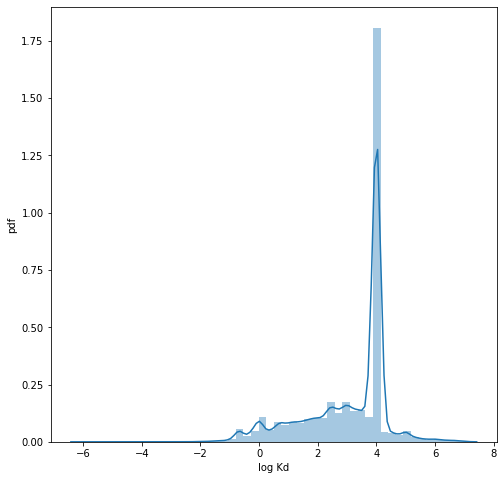

In [2]:
df = pd.read_csv('/home/sars-busters-consolidated/data/BindingDB_All.tsv', sep = '\t', error_bad_lines=False)
df = df[df['Number of Protein Chains in Target (>1 implies a multichain complex)'] == 1.0]
df = df[df['Ligand SMILES'].notnull()]

idx_str = 'Kd (nM)'

df_want = df[df[idx_str].notnull()]
df_want = df_want[['BindingDB Reactant_set_id', 'Ligand InChI', 'Ligand SMILES',\
                    'PubChem CID', 'UniProt (SwissProt) Primary ID of Target Chain',\
                    'BindingDB Target Chain  Sequence', idx_str]]

df_want.rename(columns={'BindingDB Reactant_set_id':'ID', 'Ligand SMILES':'SMILES',\
                        'Ligand InChI':'InChI', 'PubChem CID':'PubChem_ID',
                        'UniProt (SwissProt) Primary ID of Target Chain':'UniProt_ID',
                        'BindingDB Target Chain  Sequence': 'Target Sequence',
                            idx_str: 'Label'}, inplace=True)

df_want['Label'] = df_want['Label'].str.replace('>', '')
df_want['Label'] = df_want['Label'].str.replace('<', '')
df_want['Label'] = df_want['Label'].astype(float)

# have at least uniprot or pubchem ID
df_want = df_want[df_want.PubChem_ID.notnull() | df_want.UniProt_ID.notnull()]
df_want = df_want[df_want.InChI.notnull()]

df_want = df_want[(df_want.Label <= 10000000.0) & (df_want.Label != 0)]
#remove zeros
df_want=df_want[df_want['Label']>0]
print('There are ' + str(len(df_want)) + ' drug target pairs.')


kd_list = list(df_want.Label.values)
figure(figsize=(8, 8))
ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), norm_hist=True)
ax.set(xlabel='log Kd', ylabel='pdf')

In [3]:
df_want_Kd = df_want[['SMILES','Target Sequence','Label']]

threshold = 30 ## DeepPurpose threshold in nM

df_want_Kd_binary = df_want_Kd.copy()
df_want_Kd_binary['Label'] = [1 if x < threshold else 0 for x in tqdm(df_want_Kd['Label'].tolist())]

ligands = list(set(df_want_Kd_binary['SMILES'].tolist()))
targets = list(set(df_want_Kd_binary['Target Sequence'].tolist()))

target_annotations_bindingDB = []

for prot in tqdm(targets):
    sub_df = df_want_Kd_binary[df_want_Kd_binary['Target Sequence'] == prot]
    target_annotations_bindingDB.append(len(sub_df))
    
print('Average annotations for proteins: ', np.mean(target_annotations_bindingDB))

100%|██████████| 1507/1507 [00:12<00:00, 118.15it/s]

Average annotations for proteins:  46.94492368944924


## Removing batch effect from BindingDB Kd

In [4]:
df_want_Kd_binary['Constant']=df_want_Kd['Label']
df_want_Kd_binary['Constant_log']=df_want_Kd_binary['Constant'].apply(np.log)
meanlog_constant=df_want_Kd_binary['Constant_log'].mean()
stdlog_constant=df_want_Kd_binary['Constant_log'].std()
df_want_Kd_binary=df_want_Kd_binary.sort_values(by=['Constant'])
print(df_want_Kd_binary['Constant_log'].mean())
print(df_want_Kd_binary['Constant_log'].std())

ecdfkr =ECDF(df_want_Kd_binary['Constant_log'])
MAT=np.array([ecdfkr.x, ecdfkr.y, norm.ppf(ecdfkr.y, loc=meanlog_constant, scale=stdlog_constant)]).T
MAT=MAT[1:,:]
MAT[-1,2]=norm.ppf((MAT.shape[0]-0.5)/MAT.shape[0], loc=meanlog_constant, scale=stdlog_constant)
df_want_Kd_binary['Constant_lognormal']=MAT[:,2]
df_want_Kd_binary['Constant_transformed']=np.exp(df_want_Kd_binary['Constant_lognormal'])

7.104377155054556
3.3336849554043364


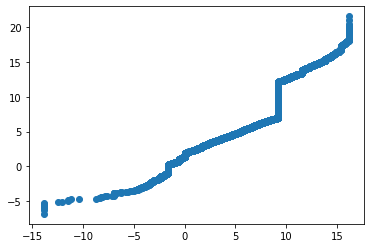

In [5]:
plt.scatter(df_want_Kd_binary['Constant_log'],df_want_Kd_binary['Constant_lognormal'] )

In [6]:
print(max(df_want_Kd_binary['Constant_log'][df_want_Kd_binary['Label']==1]))
print(max(df_want_Kd_binary['Constant_lognormal'][df_want_Kd_binary['Label']==1]))

Tlog=max(df_want_Kd_binary['Constant_lognormal'][df_want_Kd_binary['Label']==1])
df_want_Kd_binary['Labelcheck']=[1 if x < Tlog else 0 for x in tqdm(df_want_Kd_binary['Constant_lognormal'].tolist())]

100%|██████████| 70746/70746 [00:00<00:00, 1623073.14it/s]

3.3847291889548483
3.8093724849142


## Check Kd distribution after removing batch effect

100%|██████████| 1507/1507 [00:25<00:00, 58.56it/s]


[Text(0, 0.5, 'pdf'), Text(0.5, 0, 'log Kd')]

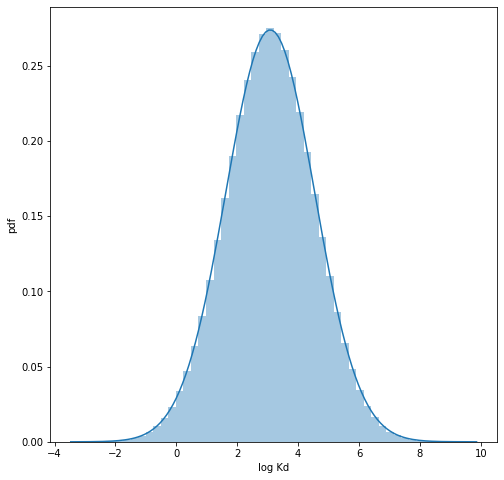

In [7]:
#tomonitor='Label'
tomonitor='Labelcheck'

#selectconstant='Constant'
selectconstant='Constant_transformed'


dictchem_kplus={}
dictchem_kminus={}
for chem in tqdm(ligands):
    dictchem_kplus[chem]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['SMILES']==chem]==1)
    dictchem_kminus[chem]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['SMILES']==chem]==0)
    
dictchem_k={chem:(dictchem_kplus[chem]+dictchem_kminus[chem]) for chem in ligands}
dictchem_ratio={chem:dictchem_kplus[chem]/dictchem_k[chem] for chem in ligands}

dicttarget_kplus={}
dicttarget_kminus={}
for t in tqdm(targets):
    dicttarget_kplus[t]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['Target Sequence']==t]==1)
    dicttarget_kminus[t]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['Target Sequence']==t]==0)
    
dicttarget_k={t:(dicttarget_kplus[t]+dicttarget_kminus[t]) for t in targets}
dicttarget_ratio={t:dicttarget_kplus[t]/dicttarget_k[t] for t in targets}

df_want_Kd_binary['k_l']=[dictchem_k[c] for c in df_want_Kd_binary['SMILES']]
df_want_Kd_binary['k_t']=[dicttarget_k[t] for t in df_want_Kd_binary['Target Sequence']]

kd_list = list(df_want_Kd_binary[selectconstant])
figure(figsize=(8, 8))
ax = sns.distplot(np.log10(kd_list), norm_hist=True)
ax.set(xlabel='log Kd', ylabel='pdf')

## Degree and associated Kd

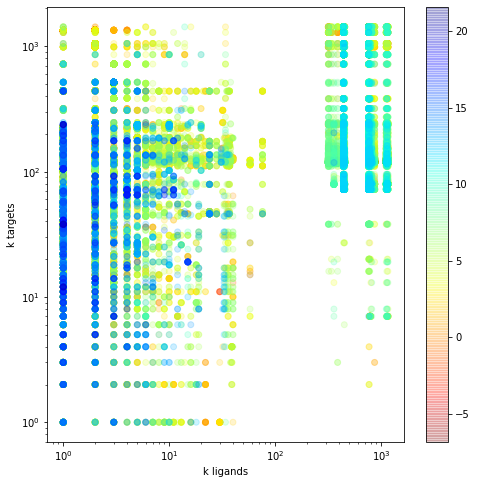

In [8]:
figure(figsize=(8, 8))
plt.scatter(df_want_Kd_binary['k_l'], df_want_Kd_binary['k_t'], c=df_want_Kd_binary[selectconstant].apply(np.log), alpha=0.2, cmap="jet_r")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k ligands')
plt.ylabel('k targets')
plt.colorbar()

## Degree ratio distributions

Text(0, 0.5, 'PDF')

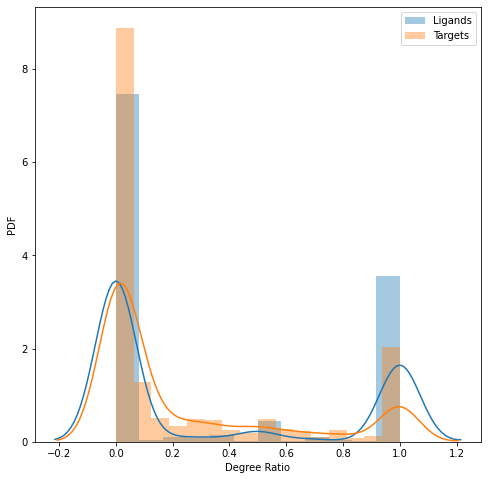

In [9]:
figure(figsize=(8, 8))
sns.distplot(list(dictchem_ratio.values()), label='Ligands')
sns.distplot(list(dicttarget_ratio.values()), label='Targets')
plt.legend()
plt.xlabel('Degree Ratio')
plt.ylabel('PDF')

# Analysing BindingDB DTI

In [10]:
B = nx.Graph()
B.add_nodes_from(ligands, bipartite=0)
B.add_nodes_from(targets, bipartite=1)
B.add_edges_from([(c,t) for c, t in df_want_Kd_binary[['SMILES', 'Target Sequence']].values])

In [11]:
nx.degree_assortativity_coefficient(B)

-0.2987859690737973

In [12]:
print(len(ligands))
print(len(targets))
print(max([B.degree(l) for l  in ligands]))
print(max([B.degree(t) for t in targets]))

13390
1507
397
1121


In [13]:
print('Number of proteins/nodes: ', len(targets))
target_annotations = []
target_average_Kd = []

for prot in tqdm(targets):
    sub_df = df_want_Kd_binary[df_want_Kd_binary['Target Sequence'] == prot]
    target_annotations.append(len(sub_df))
    target_average_Kd.append(np.mean(sub_df[selectconstant].tolist()))
    
different_target_annotations = list(set(target_annotations))
unique_Kd_targets = []

for unique_ann in tqdm(different_target_annotations):
    
    all_Kd_list = []    
    all_indices = get_all_indices(target_annotations,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(target_average_Kd[j])
        
    unique_Kd_targets.append(np.mean(all_Kd_list))
    
print('Proteins - Correlation between node k and Kd: ', stats.spearmanr(target_annotations,target_average_Kd))
print('Proteins - Correlation between k and <Kd>: ', stats.spearmanr(different_target_annotations,unique_Kd_targets))

  1%|          | 12/1507 [00:00<00:12, 116.23it/s]

Number of proteins/nodes:  1507


100%|██████████| 172/172 [00:00<00:00, 6688.30it/s]

Proteins - Correlation between node k and Kd:  SpearmanrResult(correlation=0.3399545931879757, pvalue=4.4063759957873965e-42)
Proteins - Correlation between k and <Kd>:  SpearmanrResult(correlation=-0.5421922867391626, pvalue=1.569980027727399e-14)


In [14]:
# log space
selectconstant_log='Constant_lognormal'
print('Number of proteins/nodes: ', len(targets))
target_annotations = []
target_average_Kd = []
target_std_Kd = []

for prot in tqdm(targets):
    sub_df = df_want_Kd_binary[df_want_Kd_binary['Target Sequence'] == prot]
    target_annotations.append(len(sub_df))
    target_average_Kd.append(np.mean(sub_df[selectconstant_log].tolist()))
    target_std_Kd.append(np.std(sub_df[selectconstant_log].tolist()))
    
different_target_annotations = list(set(target_annotations))
unique_Kd_targets = []
unique_std_Kd_targets = []

for unique_ann in tqdm(different_target_annotations):
    
    all_Kd_list = []    
    all_indices = get_all_indices(target_annotations,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(target_average_Kd[j])
        
    unique_Kd_targets.append(np.mean(all_Kd_list))
    unique_std_Kd_targets.append(np.std(all_Kd_list))

  1%|          | 12/1507 [00:00<00:12, 115.39it/s]

Number of proteins/nodes:  1507


100%|██████████| 172/172 [00:00<00:00, 5537.89it/s]


In [15]:
# log space
print('Proteins - Correlation between node k and Kd: ', stats.spearmanr(target_annotations,target_average_Kd))
print('Proteins - Correlation between node k and Kd std: ', stats.spearmanr(target_annotations,target_std_Kd))
print('Proteins - Correlation between k and <Kd>: ', stats.spearmanr(different_target_annotations,unique_Kd_targets))
print('Proteins - Correlation between k and <Kd> std: ', stats.spearmanr(different_target_annotations,unique_std_Kd_targets))

Proteins - Correlation between node k and Kd:  SpearmanrResult(correlation=0.2978643834993303, pvalue=2.9719005190827526e-32)
Proteins - Correlation between node k and Kd std:  SpearmanrResult(correlation=0.6653239144750266, pvalue=2.802608719918172e-193)
Proteins - Correlation between k and <Kd>:  SpearmanrResult(correlation=0.0027215504819314046, pvalue=0.9717347917051469)
Proteins - Correlation between k and <Kd> std:  SpearmanrResult(correlation=-0.7150037469560117, pvalue=3.186000265383969e-28)


Mean and standard deviation of log Kd:  7.104581746618654 3.333633341053326


Text(0, 0.5, 'Average $K_d$')

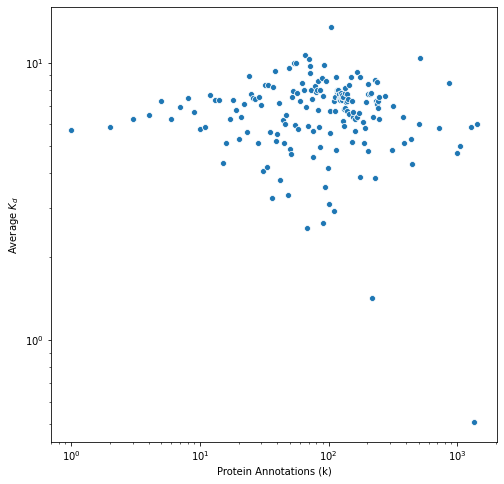

In [16]:
# this values are per link
mean_log_Kd = np.mean(np.log(kd_list))
std_log_Kd = np.std(np.log(kd_list))

#mean_log_Kd = np.mean(np.log(target_average_Kd))
#std_log_Kd = np.std(np.log(target_average_Kd))
print('Mean and standard deviation of log Kd: ', mean_log_Kd, std_log_Kd)

figure(figsize=(8, 8))
sns.scatterplot(different_target_annotations,unique_Kd_targets)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Protein Annotations (k)')
plt.ylabel(r'Average $K_d$')

Proteins - Correlation between node k and ratio:  SpearmanrResult(correlation=0.12297376446051768, pvalue=1.6838804447078744e-06)


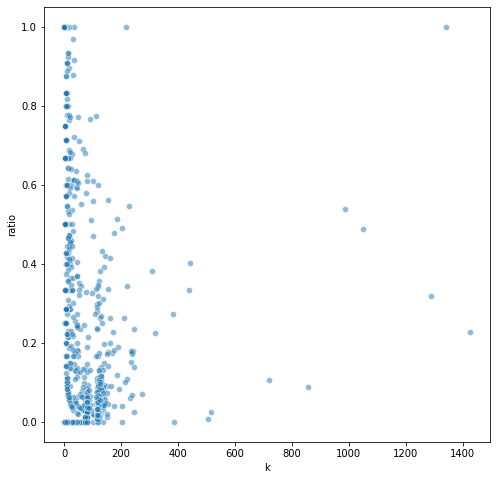

<Figure size 576x576 with 0 Axes>

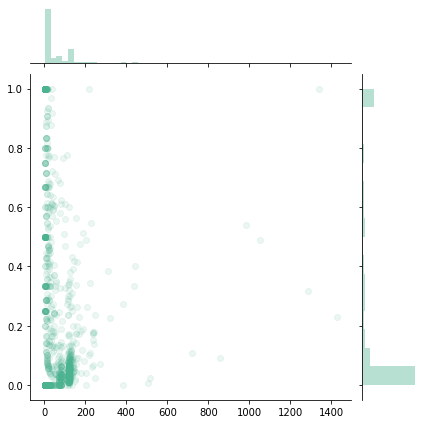

In [17]:
# targets
figure(figsize=(8, 8))
x=[dicttarget_k[t] for t in targets]
y=[dicttarget_ratio[t] for t in targets]
sns.scatterplot(x, y, alpha=0.5)
plt.xlabel('k')
plt.ylabel('ratio')


print('Proteins - Correlation between node k and ratio: ', stats.spearmanr(x,y))



figure(figsize=(8, 8))
sns.jointplot(x=[dicttarget_k[t] for t in targets],y=[dicttarget_ratio[t] for t in targets],
              color="#4CB391",
             alpha=0.1)
#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel('Protein Annotations (k)')
#plt.ylabel(r'Average $K_d$')

100%|██████████| 172/172 [00:00<00:00, 6616.29it/s]

Proteins - Correlation between node k and ratio:  SpearmanrResult(correlation=0.12297376446051768, pvalue=1.6838804447078744e-06)
Proteins - Correlation between k and <ratio>:  SpearmanrResult(correlation=-0.15479857177264986, pvalue=0.042601174923062576)


Text(0, 0.5, 'Average ratio')

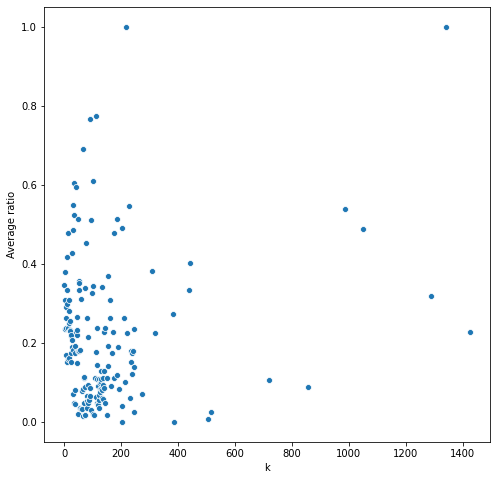

In [18]:
different_x = sorted(list(set(x)))
unique_y= []

for unique_ann in tqdm(different_x):
    
    yperx = []    
    all_indices = get_all_indices(x,unique_ann)
    
    for j in all_indices:
        yperx.append(y[j])
        
    unique_y.append(np.mean(yperx))
    
print('Proteins - Correlation between node k and ratio: ', stats.spearmanr(x, y))
print('Proteins - Correlation between k and <ratio>: ', stats.spearmanr(different_x,unique_y))


figure(figsize=(8, 8))
sns.scatterplot(different_x,unique_y)
plt.xlabel('k')
plt.ylabel('Average ratio')

In [19]:
# node with degree 1
yperx = []    
all_indices = get_all_indices(x,1)
    
for j in all_indices:
        yperx.append(y[j])
 

print(set(yperx))
print(sum(np.array(yperx)==0))
print(sum(np.array(yperx)==1))

{0.0, 1.0}
206
109


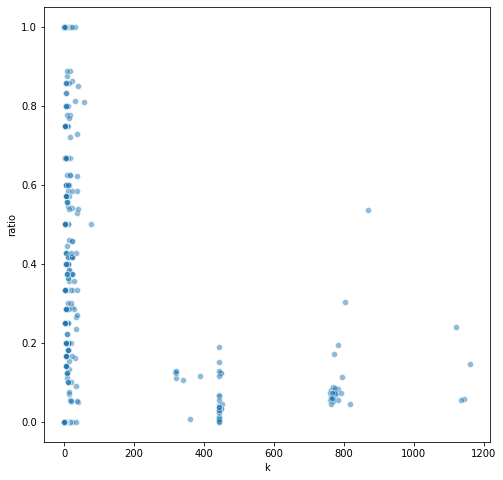

<Figure size 576x576 with 0 Axes>

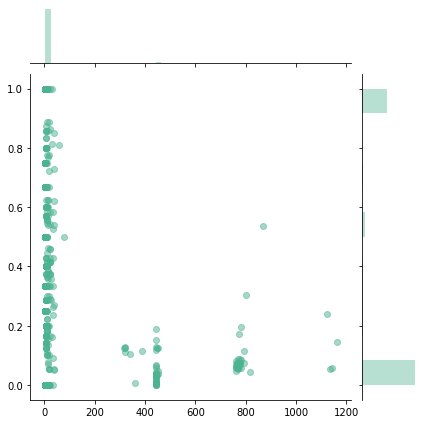

In [20]:
# ligands

figure(figsize=(8, 8))
sns.scatterplot([dictchem_k[c] for c in ligands],[dictchem_ratio[c] for c in ligands], alpha=0.5)
plt.xlabel('k')
plt.ylabel('ratio')
figure(figsize=(8, 8))
sns.jointplot(x=[dictchem_k[c] for c in ligands],y=[dictchem_ratio[c] for c in ligands],
              color="#4CB391",
             alpha=0.5)

# Power-Law + Correlation

In [21]:
std_log_Kd_original = std_log_Kd

In [22]:
print(mean_log_Kd)
print(std_log_Kd)

7.104581746618654
3.333633341053326


In [23]:
THR = 0.16 # p_bind threshold
anti_corr = -0.47 ## Same as original BindingDB data
std_log_Kd = std_log_Kd_original

In [24]:
simulated_network_nodes=len(target_annotations)

K_from_copula_list = sorted(target_annotations)

while (sum(K_from_copula_list) % 2 != 0): ## Make the degree sequence graphical
    print('Degree Sequence Non Graphical')
    non_1_degrees = []
    for x in K_from_copula_list:
        if x > 1:
            non_1_degrees.append(x)
    random_non_1_entry = np.random.choice(non_1_degrees) ## Choosing a node at random who's degree is not 1
    j = K_from_copula_list.index(random_non_1_entry)
    K_from_copula_list[j] = K_from_copula_list[j] - 1
    print(sum(K_from_copula_list) % 2 == 0)

G = nx.configuration_model(K_from_copula_list, create_using=nx.Graph(), seed=None)
G.remove_edges_from(nx.selfloop_edges(G))
degrees_from_network = [G.degree(node) for node in list(G.nodes())]

print('Max degree in degree sequence: ', max(K_from_copula_list))
print('Max degree in network: ', max(degrees_from_network))

print('Mean degree in degree sequence: ', np.mean(K_from_copula_list))
print('Mean degree in network: ', np.mean(degrees_from_network))

Max degree in degree sequence:  1426
Max degree in network:  550
Mean degree in degree sequence:  46.94492368944924
Mean degree in network:  38.098208360982085


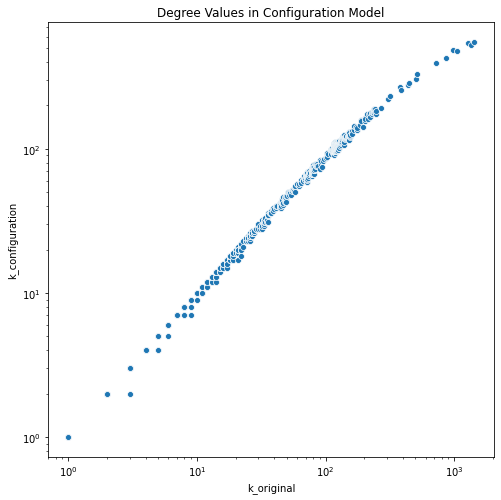

In [25]:
figure(figsize=(8, 8))
ax = sns.scatterplot(K_from_copula_list, degrees_from_network)
ax.set(title='Degree Values in Configuration Model',xscale='log',yscale='log',xlabel='k_original',ylabel='k_configuration')
plt.show()

## Without fluctuations

In [26]:
ecdfK =ECDF(degrees_from_network)
MAT=np.array([ecdfK.x, ecdfK.y, norm.ppf(ecdfK.y, loc=0, scale=1)]).T
MAT=MAT[1:,:]
#MAT[:,2][np.isinf(MAT[:,2])]=6
MAT[-1,2]=norm.ppf((MAT.shape[0]-0.5)/MAT.shape[0], loc=0, scale=1)
# in the Pearson version (make it stronger to get a value for Speraman comparable)
expMU=mean_log_Kd+anti_corr*std_log_Kd*MAT[:,2]
expSIGMA=np.sqrt((1-anti_corr**2)*(std_log_Kd**2))

MAT=np.append(MAT,norm.rvs(loc=expMU, scale=expSIGMA).reshape(len(norm.rvs(loc=expMU, scale=expSIGMA)),1), axis=1)
MAT=np.append(MAT,np.exp(MAT[:,3].reshape(MAT.shape[0],1)), axis=1)

print('Obtained Spearman', stats.spearmanr(MAT[:,1],MAT[:,3]))
print('Obtained avg log K', np.mean(MAT[:,3]))
print('Obtained std log K', np.std(MAT[:,3]))

Obtained Spearman SpearmanrResult(correlation=-0.4696764909159729, pvalue=1.5547668721848957e-83)
Obtained avg log K 6.979809342527641
Obtained std log K 3.383026583173942


In [27]:
## Check correlation between k and Kd
K_from_copula_list=list(MAT[:,0].astype(int))
Kd_from_copula_list=list(MAT[:,4])
## Checks on original Kd distribution and Kd from copula

print(np.mean(np.log(Kd_from_copula_list)))
print(mean_log_Kd)
print(np.std(np.log(Kd_from_copula_list)))
print(std_log_Kd)

## Correlation between k and Kd obtained from copula 

print('Correlation between k and Kd obtained from copula: ', stats.spearmanr(K_from_copula_list,Kd_from_copula_list))

print(sum(K_from_copula_list) % 2 == 0) ## True if graphical

## Making the degree sequence graphical

while (sum(K_from_copula_list) % 2 != 0) :
    non_1_degrees = []
    for x in K_from_copula_list:
        if x > 1:
            non_1_degrees.append(x)
    random_non_1_entry = np.random.choice(non_1_degrees) ## Choosing a node at random who's degree is not 1
    j = K_from_copula_list.index(random_non_1_entry)
    K_from_copula_list[j] = K_from_copula_list[j] - 1
    print(sum(K_from_copula_list) % 2 == 0)

## Check correlation between k and Kd

different_target_annotations_copula = list(set(K_from_copula_list))
unique_Kd_targets_copula = []

for unique_ann in tqdm(different_target_annotations_copula):
    
    all_Kd_list = []    
    all_indices = get_all_indices(K_from_copula_list,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(Kd_from_copula_list[j])
        
    unique_Kd_targets_copula.append(np.mean(all_Kd_list))
    
print('Correlation between copula generated k and <Kd>: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_targets_copula))


100%|██████████| 159/159 [00:00<00:00, 4903.67it/s]

6.979809342527641
7.104581746618654
3.383026583173942
3.333633341053326
Correlation between k and Kd obtained from copula:  SpearmanrResult(correlation=-0.4646591056161718, pvalue=1.4324331070799128e-81)
True
Correlation between copula generated k and <Kd>:  SpearmanrResult(correlation=-0.6681215667542394, pvalue=6.559135648425343e-22)


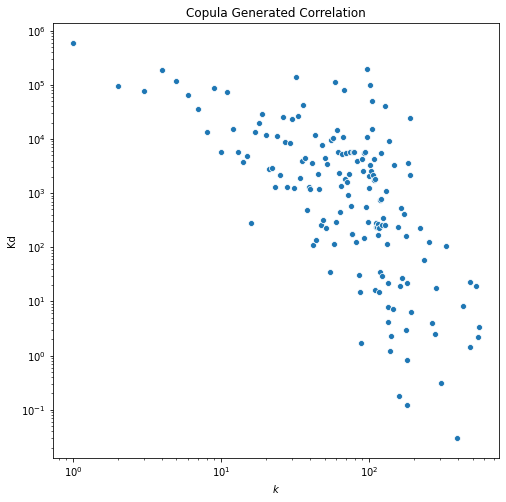

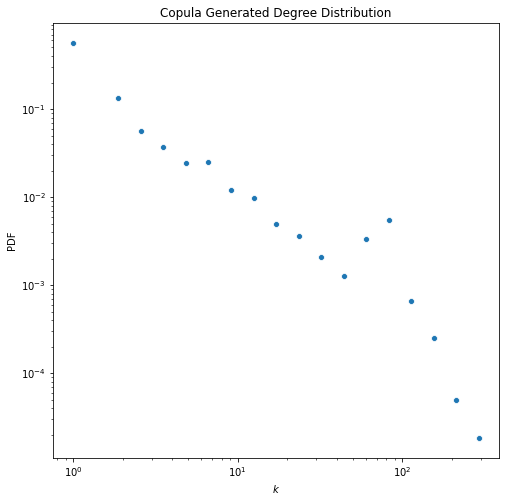

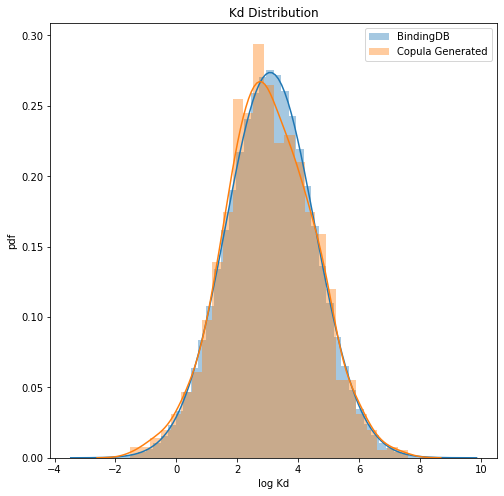

In [28]:
figure(figsize=(8, 8))
ax = sns.scatterplot(different_target_annotations_copula,unique_Kd_targets_copula,palette="#E8718C")
ax.set(title='Copula Generated Correlation',xscale='log',yscale='log',xlabel='$k$',ylabel='Kd')

figure(figsize=(8, 8))
binned_deg_ann, binned_ki_ann = log_binning_distribution(degrees_from_network,B = 20)
ax = sns.scatterplot(binned_deg_ann, binned_ki_ann,palette="#E8718C")
ax.set(title='Copula Generated Degree Distribution',xscale='log',yscale='log',xlabel='$k$',ylabel='PDF')

figure(figsize=(8, 8))
ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), label='BindingDB', norm_hist=True)
ax = sns.distplot(np.log10(Kd_from_copula_list), label='Copula Generated', norm_hist=True)
ax.set(title='Kd Distribution',xlabel='log Kd', ylabel='pdf')
plt.legend()
plt.show()

100%|██████████| 28707/28707 [00:00<00:00, 795293.76it/s]


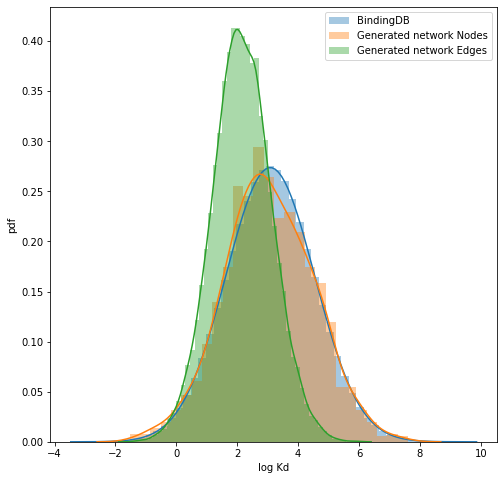

Threshold:  15.415903483521271


In [29]:
node_Kd_values = dict(zip(range(len(K_from_copula_list)), Kd_from_copula_list))
network_data = generate_network(G, node_Kd_values, kd_list, p_bind = THR)

## With fluctuations

100%|██████████| 159/159 [00:11<00:00, 13.34it/s]


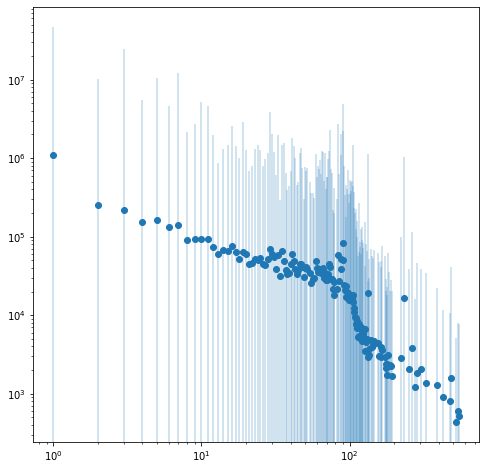

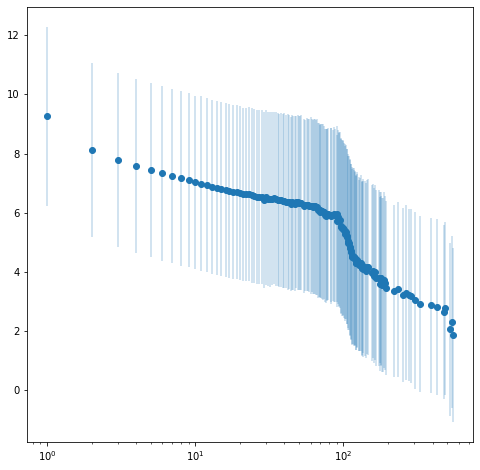

100%|██████████| 1507/1507 [00:01<00:00, 900.58it/s]


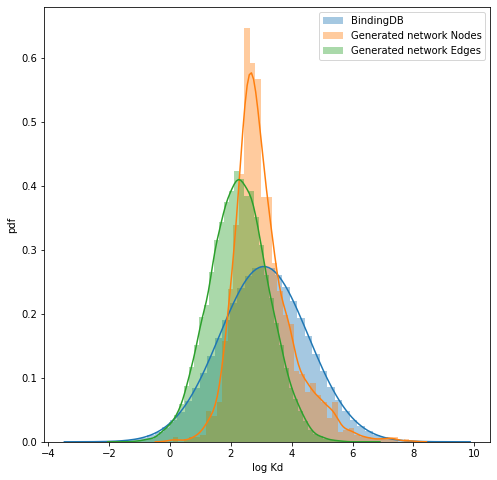

Threshold:  20.086708156516046


In [30]:
network_data_BC, degrees_from_network, node_Kd_values_avg_sampled, MATsample = sampling_with_corr(G, anti_corr, mean_log_Kd, std_log_Kd,kd_list, p_bind = THR)

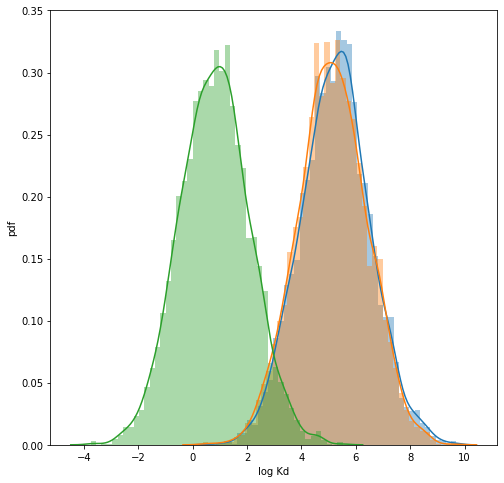

In [31]:
figure(figsize=(8, 8))
ax = sns.distplot(np.log10(MATsample[0,:]))
ax = sns.distplot(np.log10(MATsample[1,:]))
ax = sns.distplot(np.log10(MATsample[-1,:]))
ax.set(xlabel='log Kd', ylabel='pdf')
plt.show()

100%|██████████| 159/159 [00:00<00:00, 6825.59it/s]

mean log Kd from copula  7.034941050870466
mean log Kd original  7.104581746618654
std log Kd from copula  2.218222189938506
std log Kd original  3.333633341053326
Correlation between node copula generated k and Kd:  SpearmanrResult(correlation=-0.6959903721412881, pvalue=9.638450694902535e-219)
Correlation between copula generated k and <Kd>:  SpearmanrResult(correlation=-0.9660855027465965, pvalue=3.1705110534240483e-94)


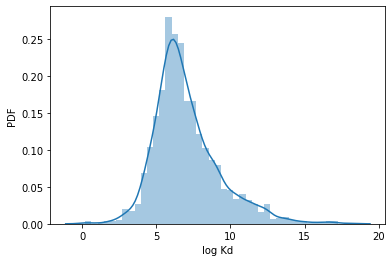

In [32]:
sns.distplot(np.log(node_Kd_values_avg_sampled))
plt.xlabel('log Kd')
plt.ylabel('PDF')

## Checks on original Kd duistribution and Kd from copula

print('mean log Kd from copula ', np.mean(np.log(node_Kd_values_avg_sampled)))
print('mean log Kd original ', mean_log_Kd)
print('std log Kd from copula ',np.std(np.log(node_Kd_values_avg_sampled)))
print('std log Kd original ',std_log_Kd)

print('Correlation between node copula generated k and Kd: ', stats.spearmanr(degrees_from_network,node_Kd_values_avg_sampled))

different_target_annotations_copula = list(set(degrees_from_network))
unique_Kd_targets_copula = []

for unique_ann in tqdm(different_target_annotations_copula):
    
    all_Kd_list = []    
    all_indices = get_all_indices(degrees_from_network,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(node_Kd_values_avg_sampled[j])
        
    unique_Kd_targets_copula.append(np.mean(all_Kd_list))
    
print('Correlation between copula generated k and <Kd>: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_targets_copula))

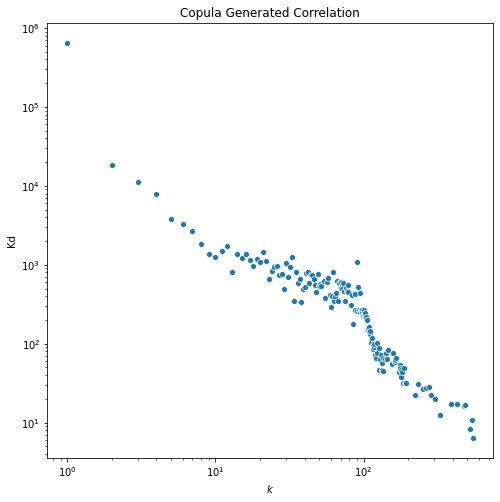

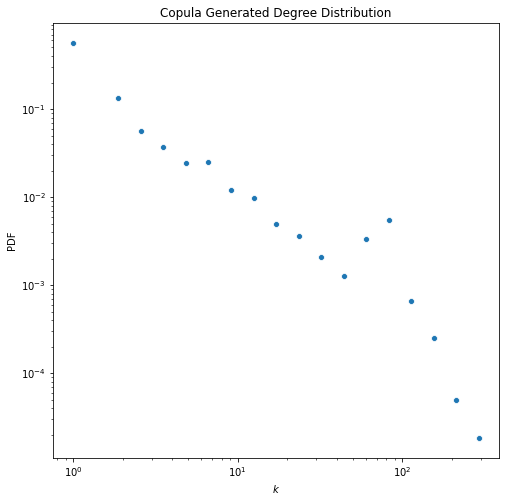

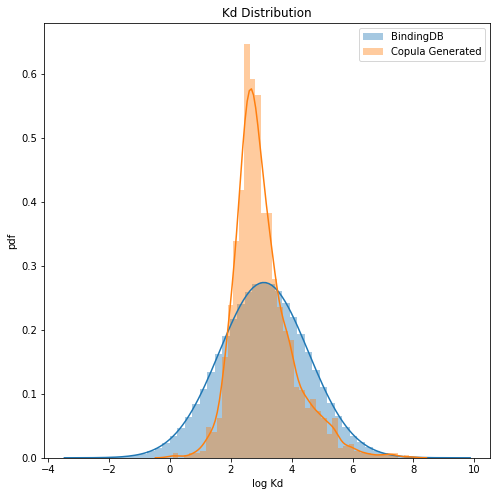

In [33]:
figure(figsize=(8, 8))
ax = sns.scatterplot(different_target_annotations_copula,unique_Kd_targets_copula)
ax.set(title='Copula Generated Correlation',xscale='log',yscale='log',xlabel='$k$',ylabel='Kd')

figure(figsize=(8, 8))
binned_deg_ann, binned_ki_ann = log_binning_distribution(degrees_from_network,B = 20)
ax = sns.scatterplot(binned_deg_ann, binned_ki_ann)
ax.set(title='Copula Generated Degree Distribution',xscale='log',yscale='log',xlabel='$k$',ylabel='PDF')

figure(figsize=(8, 8))
ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), label='BindingDB', norm_hist=True)
ax = sns.distplot(np.log10(node_Kd_values_avg_sampled), label='Copula Generated', norm_hist=True)
ax.set(title='Kd Distribution',xlabel='log Kd', ylabel='pdf')
plt.legend()
plt.show()

## Configuration model without fluctuations

100%|██████████| 1393/1393 [00:03<00:00, 442.40it/s]


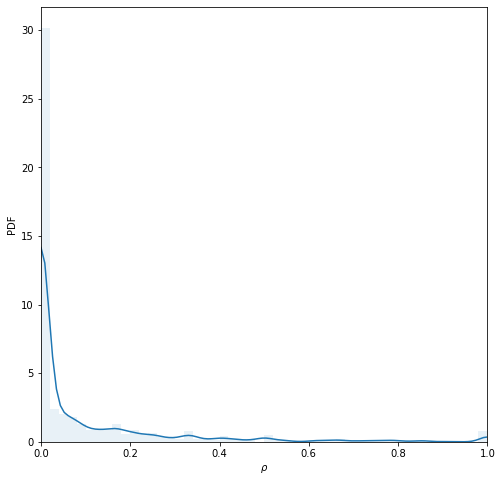

  0%|          | 2/10000 [00:00<11:05, 15.02it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.15571115059044832


  0%|          | 40/10000 [00:02<11:09, 14.89it/s]
97it [00:00, 965.59it/s]

Loops  41
Error margin:  [8.64359468e-06]


8613it [00:09, 928.67it/s]


AUC:  0.9469401585400191
AUP:  0.8772095830147473
Transductive performance:
AUC:  0.9480176994322045
AUP:  0.8854100529814728


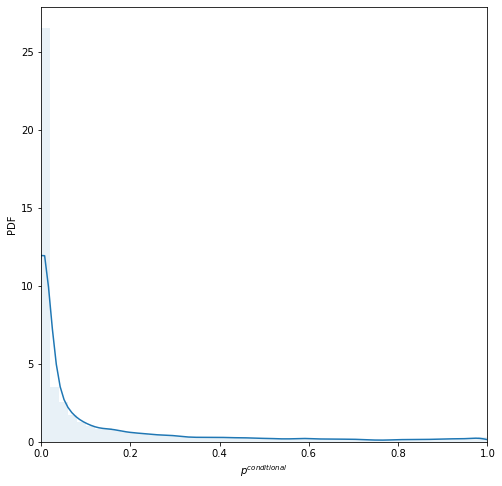

In [34]:
run_configuration_model(network_data)

100%|██████████| 1402/1402 [00:02<00:00, 468.31it/s]


Number of zero positive degree  812
Mean positive degree  4.507845934379458
Std positive degree  14.682090308143867
%%%%%%%
Mean negative degree  24.156918687589158
Std negative degree  32.225284438226915
%%%%%%%
Mean degree  28.664764621968615
Std degree  40.30497538669107


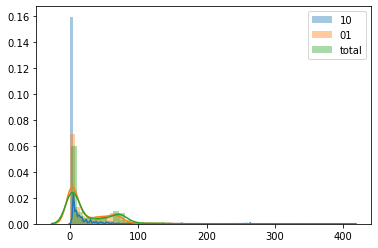

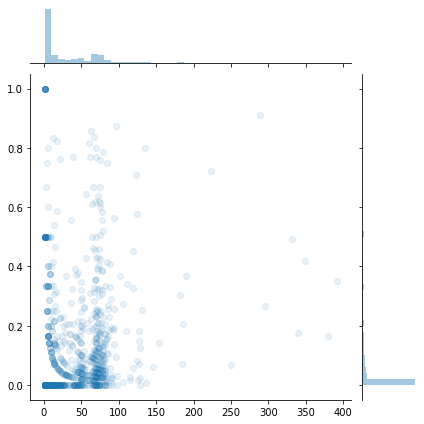

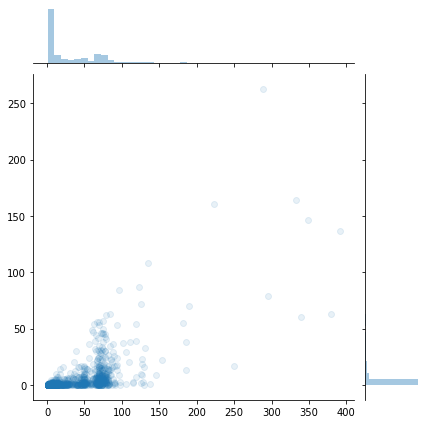

In [60]:
train, test = train_test_split(network_data, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              #color="#4CB391",
              alpha=0.1)


sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              #color="#4CB391",
              alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

## Configuration model with fluctuations

100%|██████████| 1377/1377 [00:03<00:00, 455.62it/s]


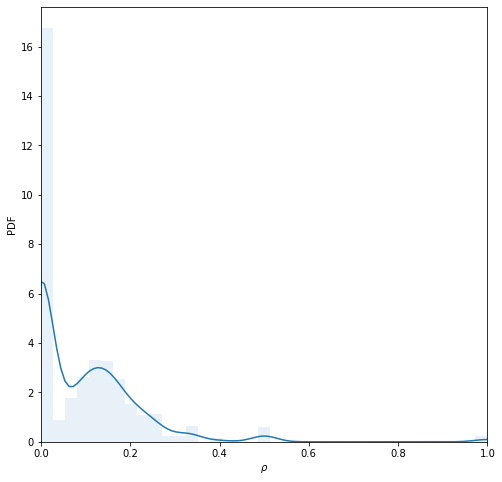

  0%|          | 2/10000 [00:00<10:44, 15.51it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.15957780332323127


  1%|          | 53/10000 [00:03<10:58, 15.10it/s]
95it [00:00, 945.04it/s]

Loops  54
Error margin:  [8.68572582e-06]


8613it [00:09, 942.99it/s]


AUC:  0.6430355549286624
AUP:  0.25925107160658195
Transductive performance:
AUC:  0.6448038362583903
AUP:  0.26244742104370433


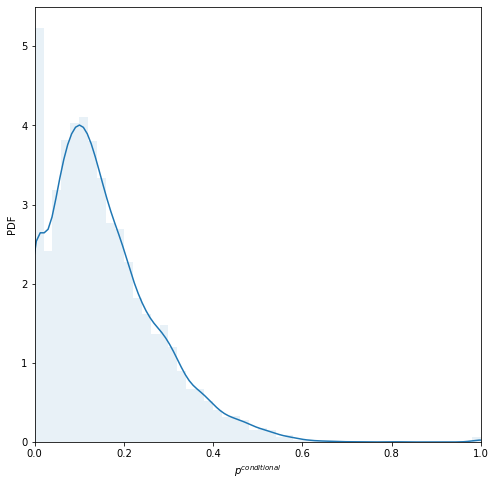

In [36]:
run_configuration_model(network_data_BC)

100%|██████████| 1382/1382 [00:02<00:00, 489.16it/s]


Number of zero positive degree  628
Mean positive degree  4.6685962373371925
Std positive degree  10.16820251141259
%%%%%%%
Mean negative degree  24.410998552821997
Std negative degree  31.30260033702666
%%%%%%%
Mean degree  29.079594790159188
Std degree  40.46671681437107


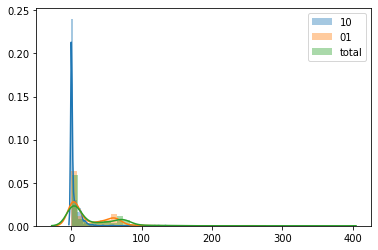

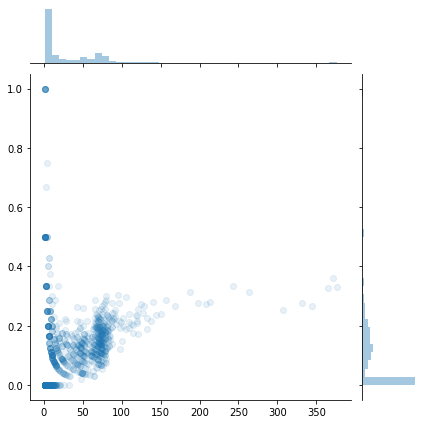

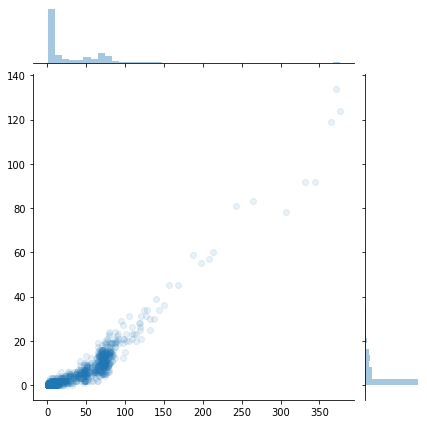

In [61]:
train, test = train_test_split(network_data_BC, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              #color="#4CB391",
              alpha=0.1)



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              #color="#4CB391",
              alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

## Other checks

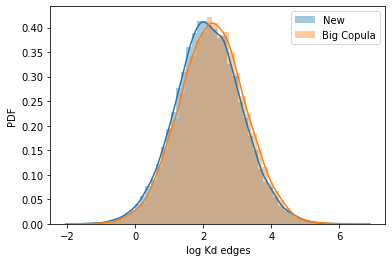

In [38]:
sns.distplot(np.log10(network_data['edge_Kd']), label='New')
sns.distplot(np.log10(network_data_BC['edge_Kd']), label='Big Copula')
plt.xlabel('log Kd edges')
plt.ylabel('PDF')
plt.legend()

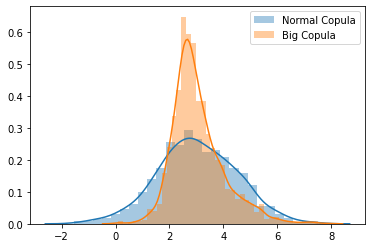

In [39]:
sns.distplot(np.log10(Kd_from_copula_list), label='Normal Copula')
sns.distplot(np.log10(node_Kd_values_avg_sampled), label='Big Copula')
plt.legend()

# Power-Law + No Correlation

## Without fluctuations 

  3%|▎         | 48/1401 [00:00<00:02, 476.85it/s]

Correlation between k and <Kd>:  SpearmanrResult(correlation=0.15081502268927635, pvalue=0.05775294442837942)


100%|██████████| 1401/1401 [00:02<00:00, 473.14it/s]


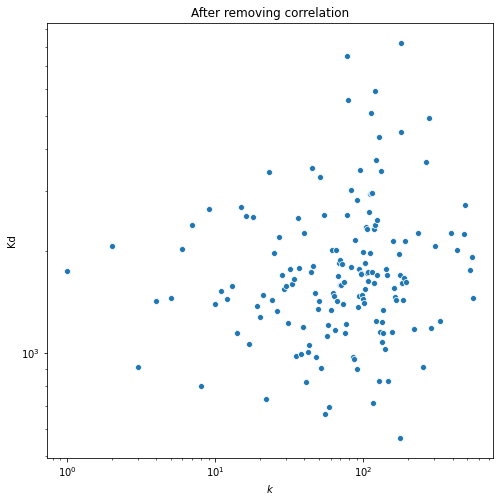

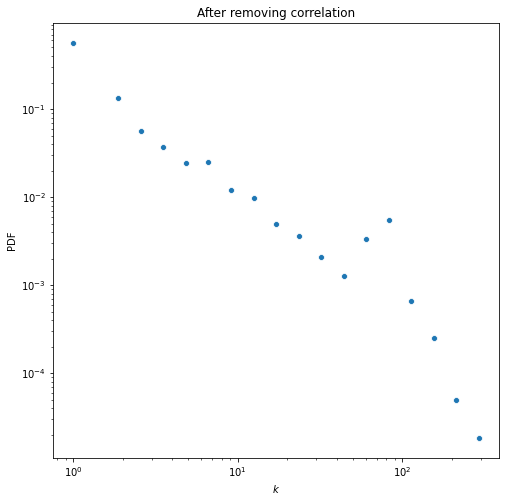

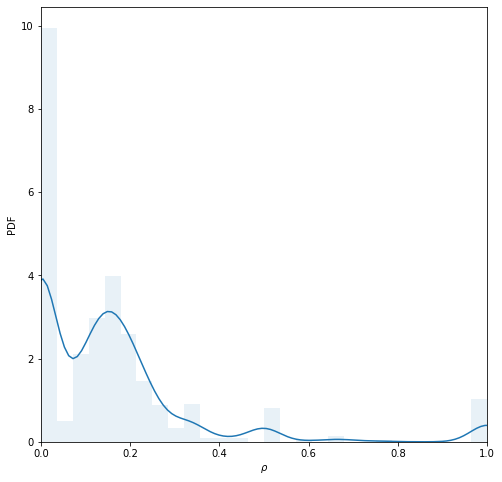

  0%|          | 2/10000 [00:00<11:34, 14.40it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.15571115059044832


  1%|          | 89/10000 [00:05<10:58, 15.05it/s]
86it [00:00, 858.25it/s]

Loops  90
Error margin:  [9.37124647e-06]


8613it [00:09, 937.84it/s]


AUC:  0.5356051672935563
AUP:  0.17115201958729914
Transductive performance:
AUC:  0.5365139982836273
AUP:  0.1724413712103375


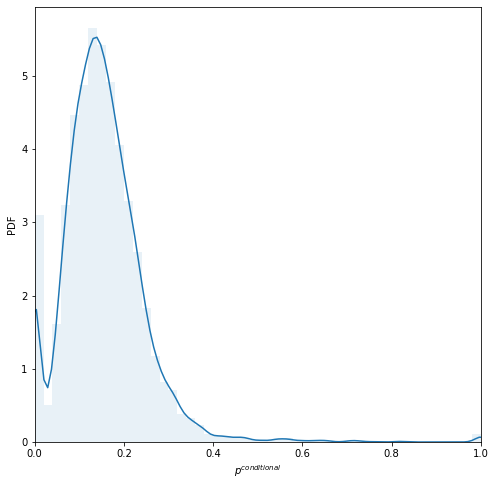

In [40]:
network_data_shuffled = remove_correlation_run_configuration_model(network_data, precision=10**(-5), loops=10000)

100%|██████████| 1399/1399 [00:03<00:00, 460.29it/s]


Number of zero positive degree  516
Mean positive degree  4.473195139385275
Std positive degree  6.632212034252341
%%%%%%%
Mean negative degree  24.253037884203003
Std negative degree  34.307552612416806
%%%%%%%
Mean degree  28.72623302358828
Std degree  40.54489606636315


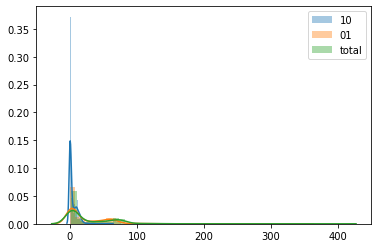

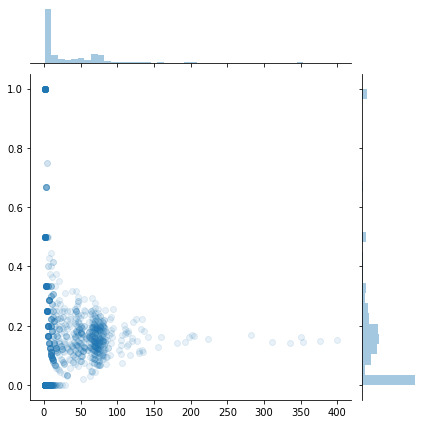

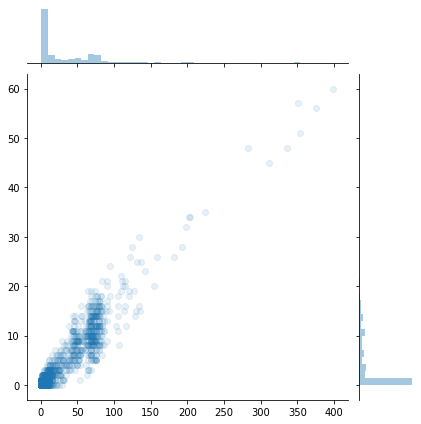

In [63]:
train, test = train_test_split(network_data_shuffled, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()

sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              #color="#4CB391",
              alpha=0.1)


sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              #color="#4CB391",
              alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

## With fluctuations 

  3%|▎         | 44/1405 [00:00<00:03, 430.99it/s]

Correlation between k and <Kd>:  SpearmanrResult(correlation=0.022059350370193458, pvalue=0.7825506101997582)


100%|██████████| 1405/1405 [00:02<00:00, 478.18it/s]


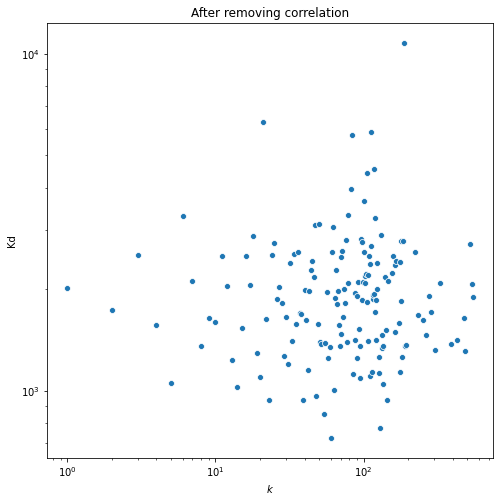

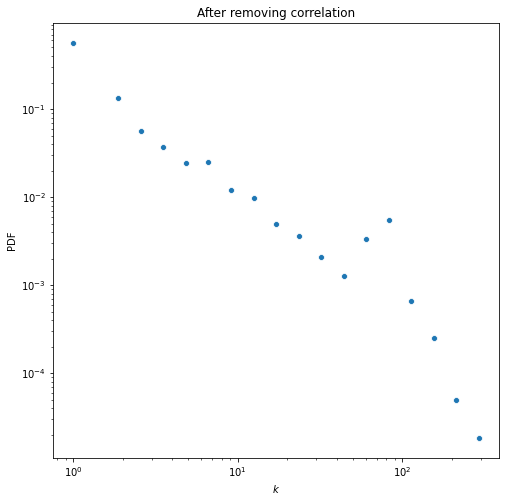

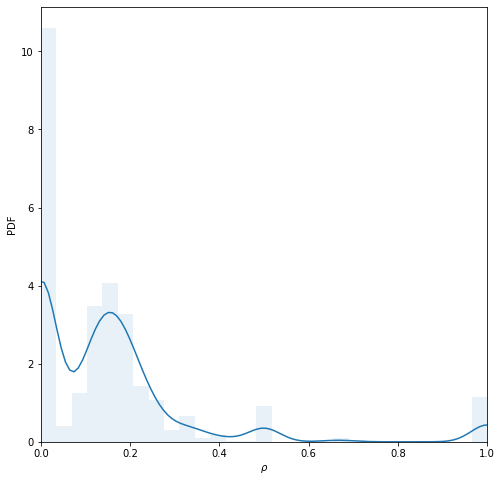

  0%|          | 2/10000 [00:00<11:03, 15.07it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.15957780332323127


  1%|          | 84/10000 [00:05<10:56, 15.10it/s]
90it [00:00, 892.23it/s]

Loops  85
Error margin:  [8.62944883e-06]


8613it [00:09, 924.82it/s]


AUC:  0.5058056761594958
AUP:  0.1663902561893726
Transductive performance:
AUC:  0.5064325257088175
AUP:  0.1670432253608663


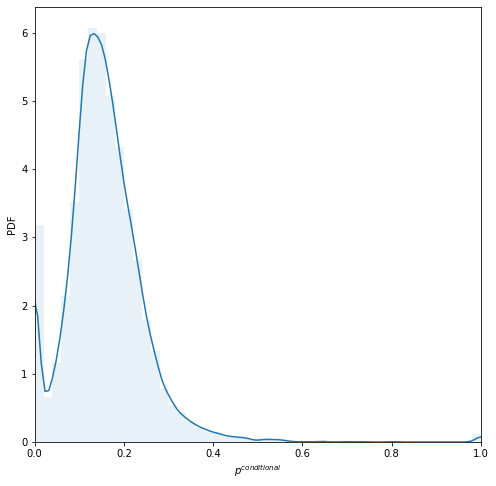

In [42]:
network_data_BC_shuffled = remove_correlation_run_configuration_model(network_data_BC, precision=10**(-5), loops=10000)

100%|██████████| 1390/1390 [00:02<00:00, 467.98it/s]


Number of zero positive degree  514
Mean positive degree  4.674820143884892
Std positive degree  7.094481526730434
%%%%%%%
Mean negative degree  24.237410071942445
Std negative degree  33.80068168692616
%%%%%%%
Mean degree  28.91223021582734
Std degree  40.55014918127009


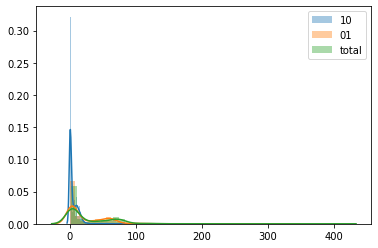

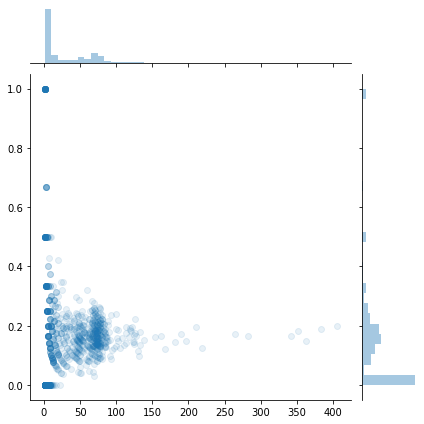

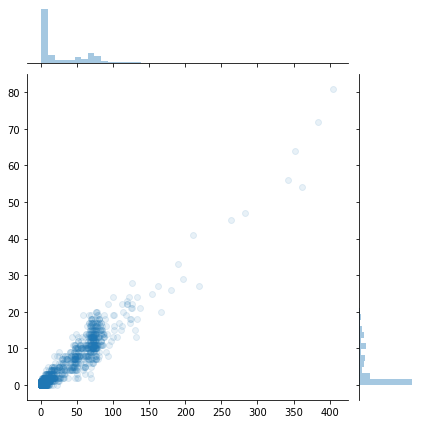

In [62]:
train, test = train_test_split(network_data_BC_shuffled, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()

sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              #color="#4CB391",
              alpha=0.1)


sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              #color="#4CB391",
              alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

100%|██████████| 159/159 [00:00<00:00, 4296.36it/s]


Correlation between k and <Kd>:  SpearmanrResult(correlation=0.022059350370193458, pvalue=0.7825506101997582)


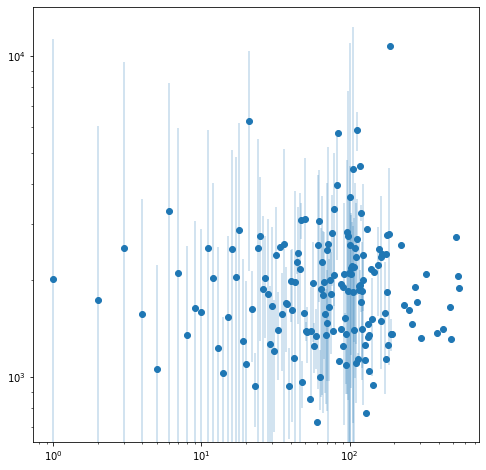

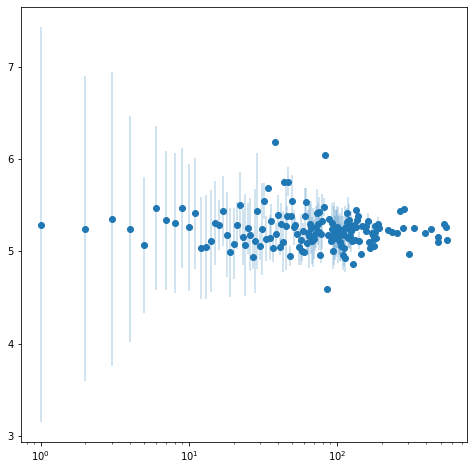

In [44]:
plot_k_Kd_relation(network_data_BC_shuffled)

# Poisson + Correlation

In [45]:
K_from_copula_listP=list(poisson.rvs(np.mean(degrees_from_network), size=simulated_network_nodes))

while (sum(K_from_copula_listP) % 2 != 0):
    print('Degree Sequence Non Graphical')
    non_1_degrees = []
    for x in K_from_copula_listP:
        if x > 1:
            non_1_degrees.append(x)
    random_non_1_entry = np.random.choice(non_1_degrees) ## Choosing a node at random who's degree is not 1
    j = K_from_copula_listP.index(random_non_1_entry)
    K_from_copula_listP[j] = K_from_copula_listP[j] - 1
    print(sum(K_from_copula_listP) % 2 == 0)

GP = nx.configuration_model(K_from_copula_listP, create_using=nx.Graph(), seed=None)
GP.remove_edges_from(nx.selfloop_edges(GP))
degrees_from_networkP = [GP.degree(node) for node in list(G.nodes())]

print('Max degree in degree sequence: ', max(K_from_copula_listP))
print('Max degree in network: ', max(degrees_from_networkP))

print('Mean degree in degree sequence: ', np.mean(K_from_copula_listP))
print('Mean degree in network: ', np.mean(degrees_from_networkP))

Max degree in degree sequence:  61
Max degree in network:  61
Mean degree in degree sequence:  38.39814200398142
Mean degree in network:  37.861977438619775


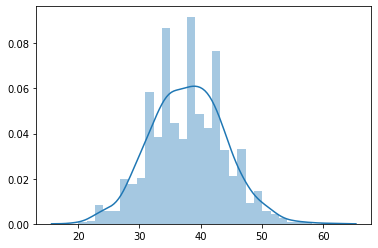

In [46]:
sns.distplot(degrees_from_networkP)

100%|██████████| 28529/28529 [00:00<00:00, 790592.25it/s]


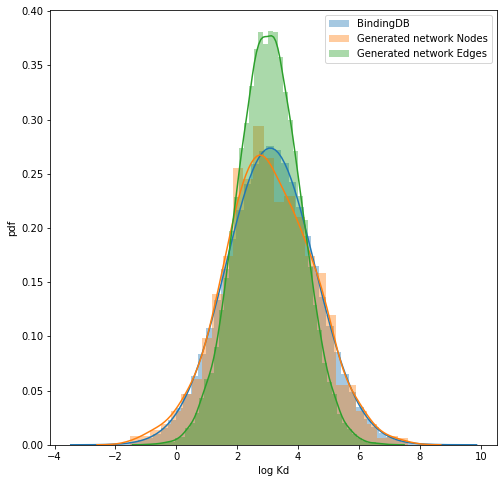

Threshold:  101.36646445561288


In [47]:
node_Kd_valuesP = dict(zip(range(len(K_from_copula_listP)), Kd_from_copula_list))
network_dataP = generate_network(GP, node_Kd_valuesP, kd_list, p_bind = THR)

## Without fluctuation 

100%|██████████| 1507/1507 [00:03<00:00, 490.59it/s]


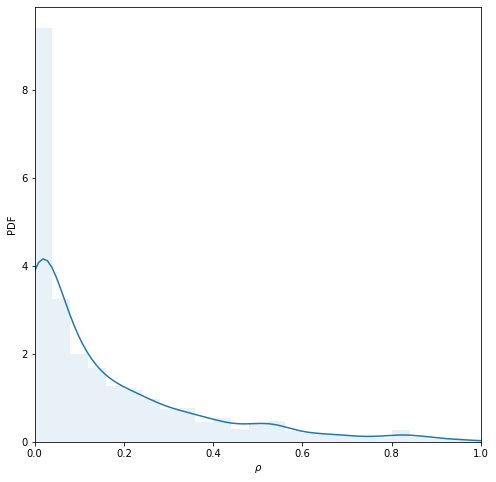

  0%|          | 2/10000 [00:00<14:32, 11.45it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.15854043254232536


  3%|▎         | 314/10000 [00:23<12:11, 13.23it/s]
143it [00:00, 1424.90it/s]

Loops  315
Error margin:  [9.66877684e-06]


8559it [00:06, 1356.58it/s]


AUC:  0.9380498113874869
AUP:  0.8702774836105686
Transductive performance:
AUC:  0.9380498113874869
AUP:  0.8702774836105686


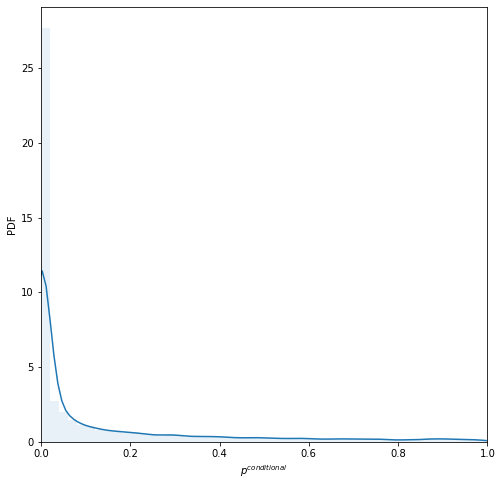

In [48]:
run_configuration_model(network_dataP, precision=10**(-5), loops=10000)

100%|██████████| 1507/1507 [00:03<00:00, 470.74it/s]


Number of zero positive degree  466
Mean positive degree  4.1619110816191105
Std positive degree  5.415116452593235
%%%%%%%
Mean negative degree  22.34107498341075
Std negative degree  6.956623948496918
%%%%%%%
Mean degree  26.502986065029862
Std degree  5.089428297946492


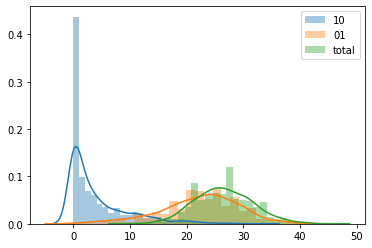

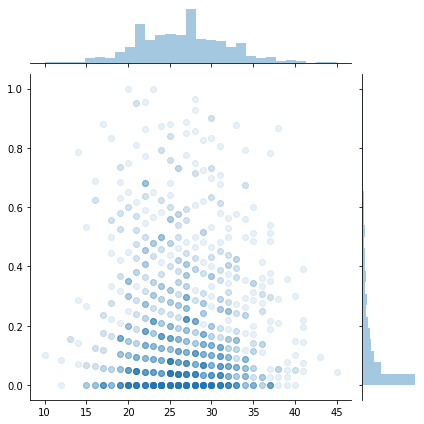

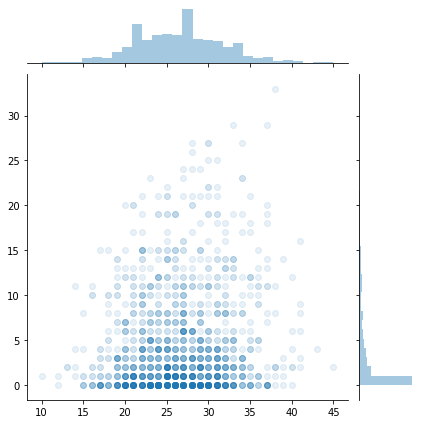

In [64]:
train, test = train_test_split(network_dataP, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()

sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              #color="#4CB391",
              alpha=0.1)


sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              #color="#4CB391",
              alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

## With fluctuations 

100%|██████████| 38/38 [00:07<00:00,  4.94it/s]


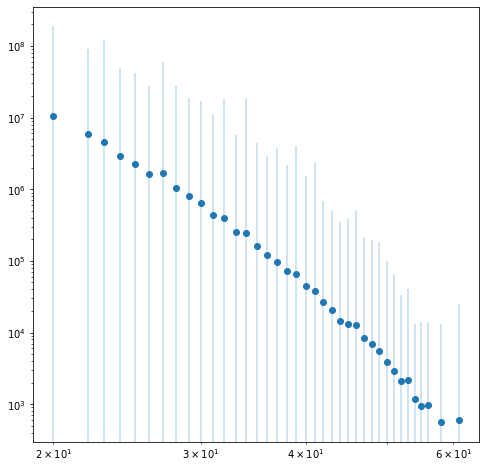

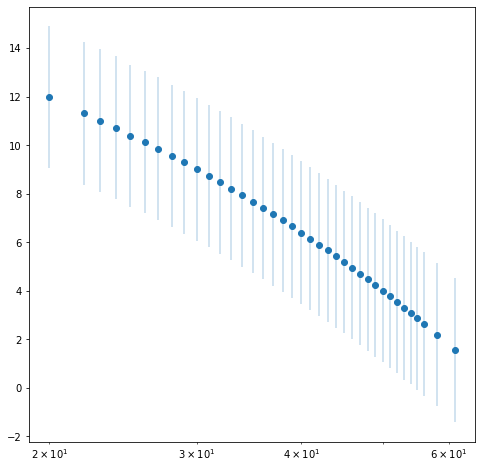

100%|██████████| 1507/1507 [00:01<00:00, 910.36it/s]


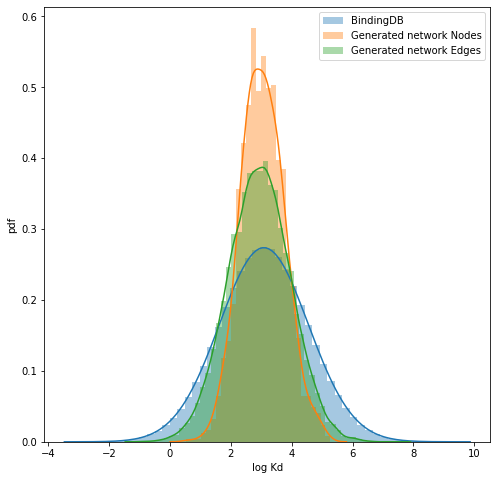

Threshold:  83.27033059602975


In [50]:
network_data_BC_P, degrees_from_networkP, node_Kd_values_avg_sampledP, MATsampleP = sampling_with_corrP(GP, anti_corr, mean_log_Kd, std_log_Kd,kd_list, p_bind = THR)

100%|██████████| 38/38 [00:00<00:00, 6209.43it/s]

mean log Kd from copula  7.005105708870729
mean log Kd original  7.104581746618654
std log Kd from copula  1.6413276864827806
std log Kd original  3.333633341053326
Correlation between node copula generated k and Kd:  SpearmanrResult(correlation=-0.9497853587923847, pvalue=0.0)
Correlation between copula generated k and <Kd>:  SpearmanrResult(correlation=-0.9989057883794725, pvalue=1.7350394553704363e-49)


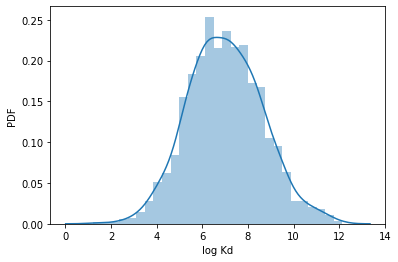

In [51]:
sns.distplot(np.log(node_Kd_values_avg_sampledP))
plt.xlabel('log Kd')
plt.ylabel('PDF')

## Checks on original Kd duistribution and Kd from copula

print('mean log Kd from copula ', np.mean(np.log(node_Kd_values_avg_sampledP)))
print('mean log Kd original ', mean_log_Kd)
print('std log Kd from copula ',np.std(np.log(node_Kd_values_avg_sampledP)))
print('std log Kd original ',std_log_Kd)

print('Correlation between node copula generated k and Kd: ', stats.spearmanr(degrees_from_networkP,node_Kd_values_avg_sampledP))

different_target_annotations_copula = list(set(degrees_from_networkP))
unique_Kd_targets_copula = []

for unique_ann in tqdm(different_target_annotations_copula):
    
    all_Kd_list = []    
    all_indices = get_all_indices(degrees_from_networkP,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(node_Kd_values_avg_sampledP[j])
        
    unique_Kd_targets_copula.append(np.mean(all_Kd_list))
    
print('Correlation between copula generated k and <Kd>: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_targets_copula))

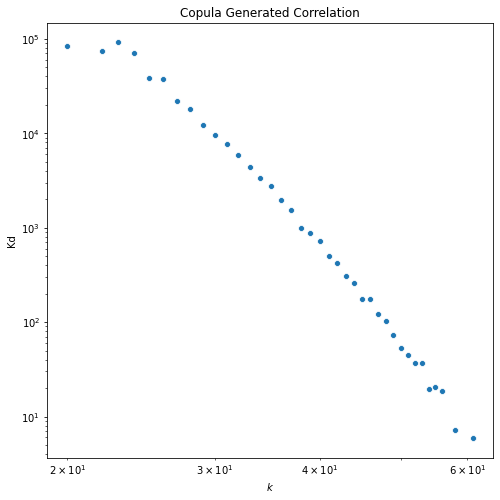

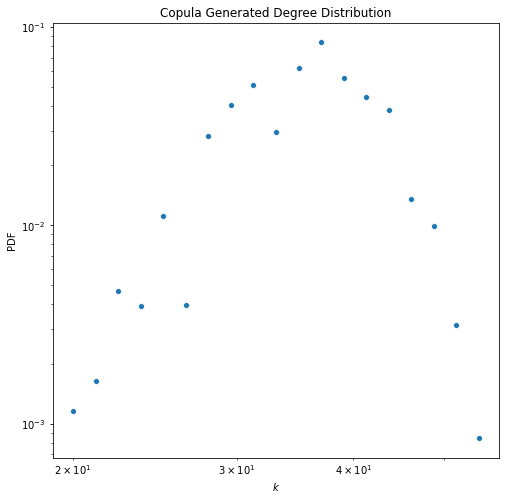

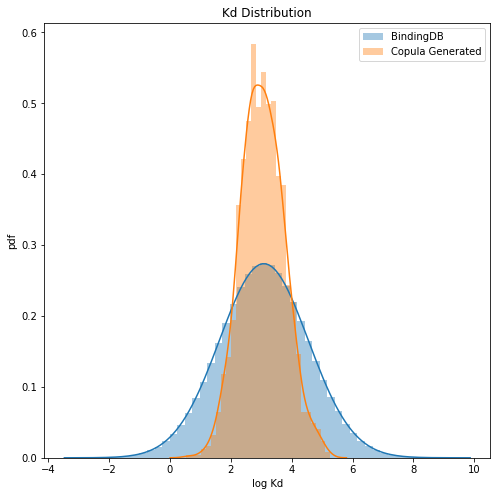

In [52]:
figure(figsize=(8, 8))
ax = sns.scatterplot(different_target_annotations_copula,unique_Kd_targets_copula)
ax.set(title='Copula Generated Correlation',xscale='log',yscale='log',xlabel='$k$',ylabel='Kd')

figure(figsize=(8, 8))
binned_deg_ann, binned_ki_ann = log_binning_distribution(degrees_from_networkP,B = 20)
ax = sns.scatterplot(binned_deg_ann, binned_ki_ann)
ax.set(title='Copula Generated Degree Distribution',xscale='log',yscale='log',xlabel='$k$',ylabel='PDF')

figure(figsize=(8, 8))
ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), label='BindingDB', norm_hist=True)
ax = sns.distplot(np.log10(node_Kd_values_avg_sampledP), label='Copula Generated', norm_hist=True)
ax.set(title='Kd Distribution',xlabel='log Kd', ylabel='pdf')
plt.legend()
plt.show()

100%|██████████| 1507/1507 [00:03<00:00, 485.69it/s]


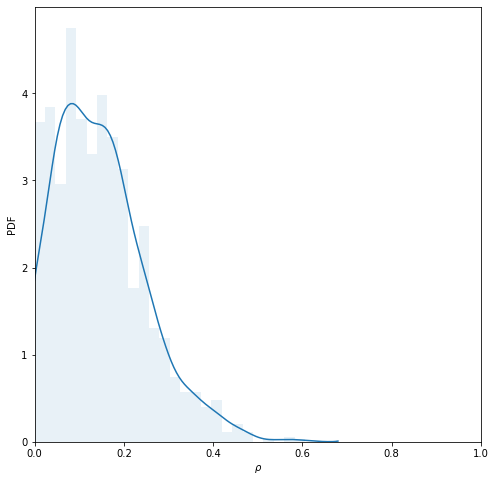

  0%|          | 2/10000 [00:00<13:42, 12.16it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.15966209821585053


  5%|▌         | 502/10000 [00:38<12:02, 13.15it/s]
132it [00:00, 1311.34it/s]

Loops  503
Error margin:  [9.9093196e-06]


8559it [00:06, 1350.19it/s]


AUC:  0.6768691969950253
AUP:  0.29437007115038116
Transductive performance:
AUC:  0.6768691969950253
AUP:  0.29437007115038116


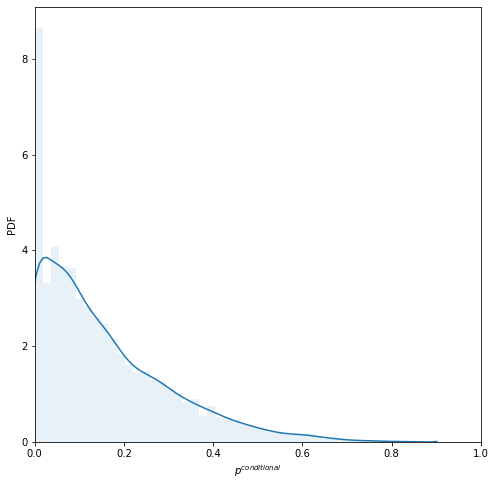

In [53]:
run_configuration_model(network_data_BC_P, loops=10000)

100%|██████████| 1507/1507 [00:03<00:00, 475.55it/s]


Number of zero positive degree  132
Mean positive degree  4.238885202388852
Std positive degree  3.4793924874483504
%%%%%%%
Mean negative degree  22.26410086264101
Std negative degree  3.5405404362051898
%%%%%%%
Mean degree  26.502986065029862
Std degree  5.161154518834994


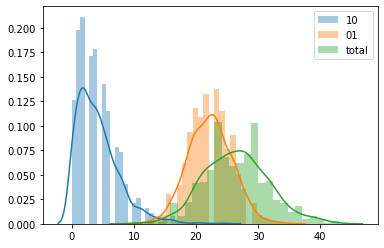

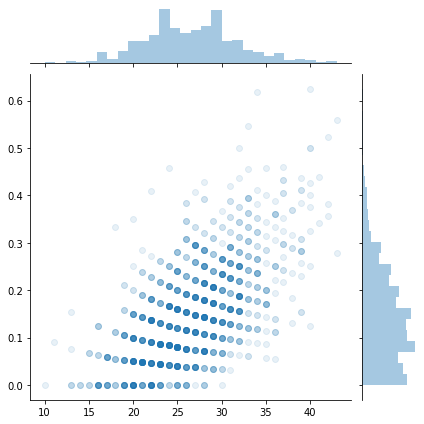

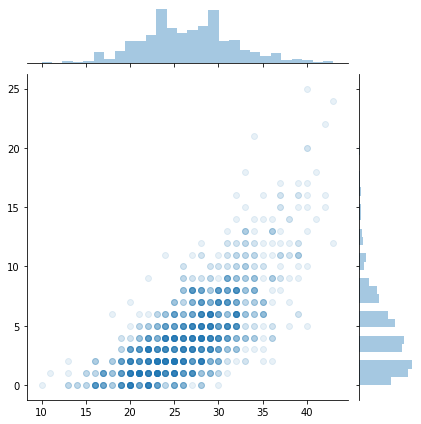

In [65]:
train, test = train_test_split(network_data_BC_P, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              #color="#4CB391",
              alpha=0.1)



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              #color="#4CB391",
              alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

# Poisson + No Correlation

## Without fluctuations

  3%|▎         | 48/1507 [00:00<00:03, 475.83it/s]

Correlation between k and <Kd>:  SpearmanrResult(correlation=-0.22704891125943757, pvalue=0.17042186254044758)


100%|██████████| 1507/1507 [00:03<00:00, 492.16it/s]


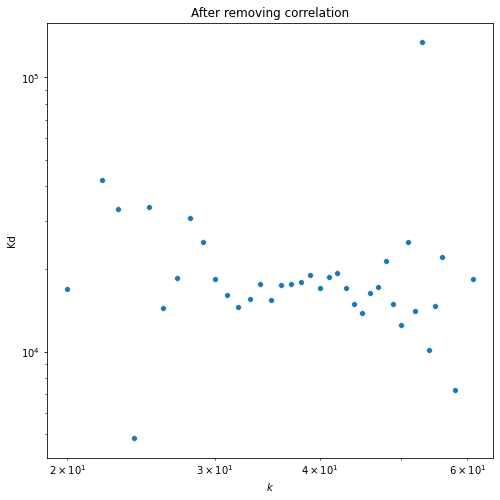

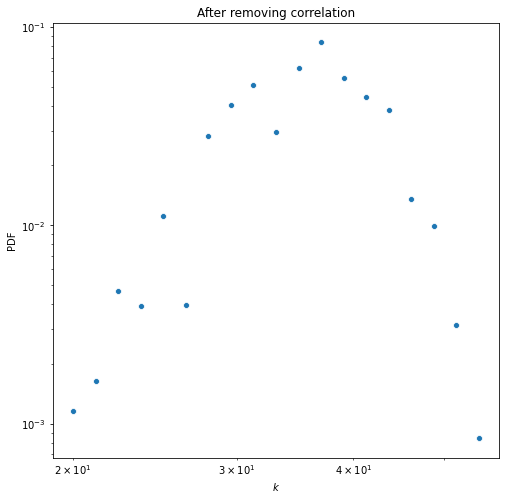

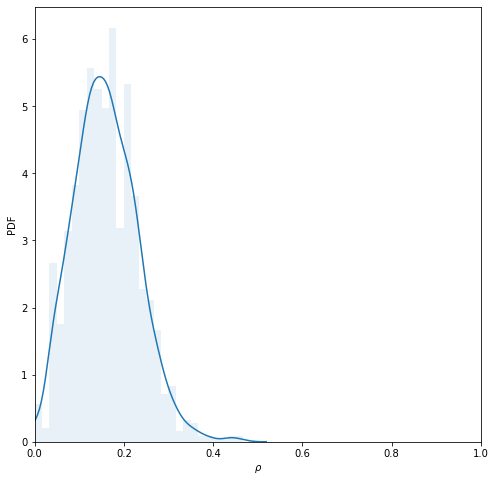

  0%|          | 2/10000 [00:00<13:29, 12.35it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.15854043254232536


  5%|▌         | 532/10000 [00:40<11:59, 13.15it/s]
140it [00:00, 1397.19it/s]

Loops  533
Error margin:  [9.79497687e-06]


8559it [00:06, 1359.44it/s]


AUC:  0.5007500698528913
AUP:  0.15787935830254876
Transductive performance:
AUC:  0.5007500698528913
AUP:  0.15787935830254876


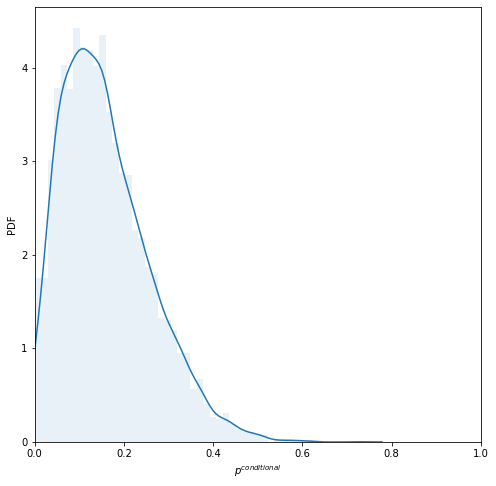

In [55]:
network_dataP_shuffled = remove_correlation_run_configuration_model(network_dataP, precision=10**(-5), loops=10000)

100%|██████████| 1507/1507 [00:03<00:00, 501.08it/s]


Number of zero positive degree  16
Mean positive degree  4.175182481751825
Std positive degree  2.0006223027895738
%%%%%%%
Mean negative degree  22.327803583278037
Std negative degree  4.76592535390611
%%%%%%%
Mean degree  26.502986065029862
Std degree  5.108168807101975


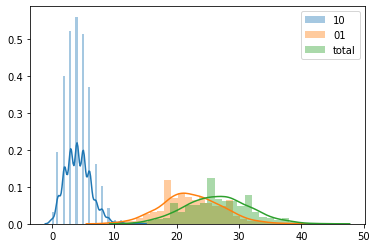

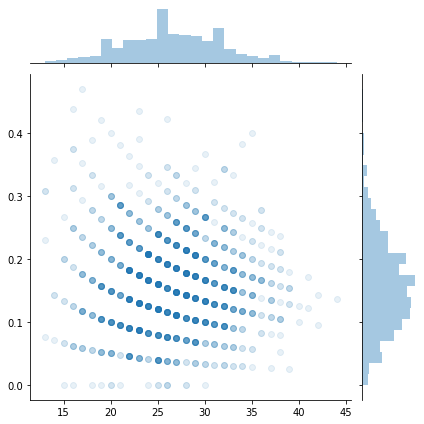

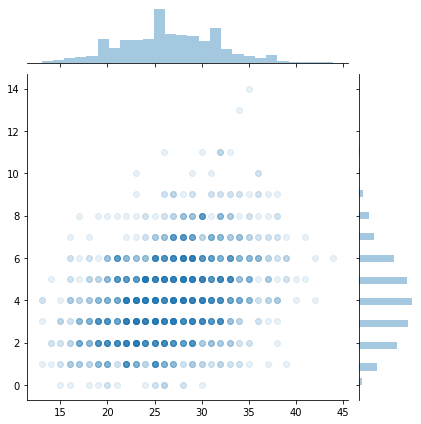

In [66]:
train, test = train_test_split(network_dataP_shuffled, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              #color="#4CB391",
              alpha=0.1)



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              #color="#4CB391",
              alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

## With fluctuation

  3%|▎         | 45/1507 [00:00<00:03, 447.57it/s]

Correlation between k and <Kd>:  SpearmanrResult(correlation=0.5461210198052303, pvalue=0.00038996108834437275)


100%|██████████| 1507/1507 [00:03<00:00, 474.58it/s]


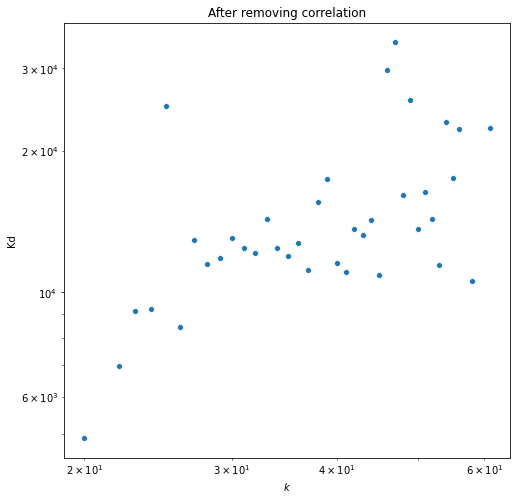

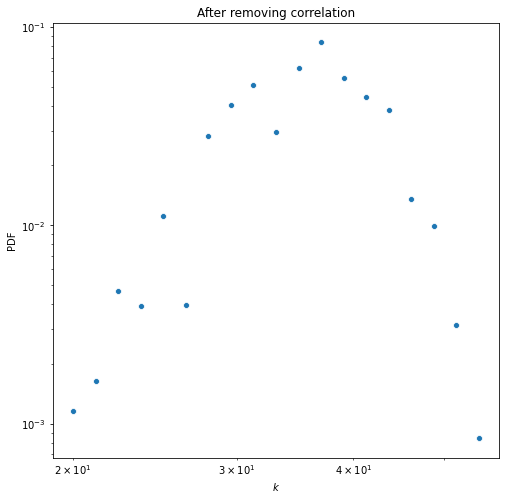

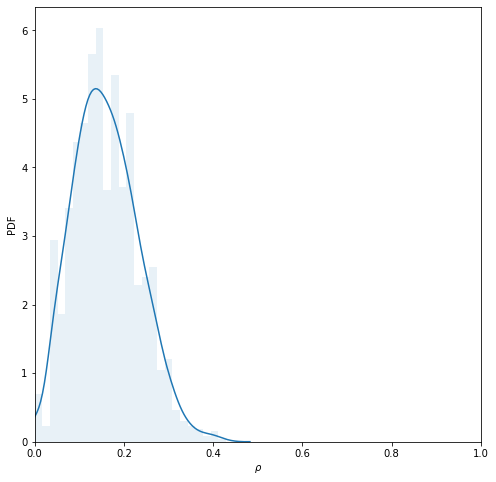

  0%|          | 2/10000 [00:00<14:18, 11.65it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.15966209821585053


  6%|▌         | 610/10000 [00:46<11:50, 13.22it/s]
130it [00:00, 1295.29it/s]

Loops  611
Error margin:  [9.96491232e-06]


8559it [00:06, 1337.66it/s]


AUC:  0.49133124846701004
AUP:  0.15666905768272396
Transductive performance:
AUC:  0.49133124846701004
AUP:  0.15666905768272396


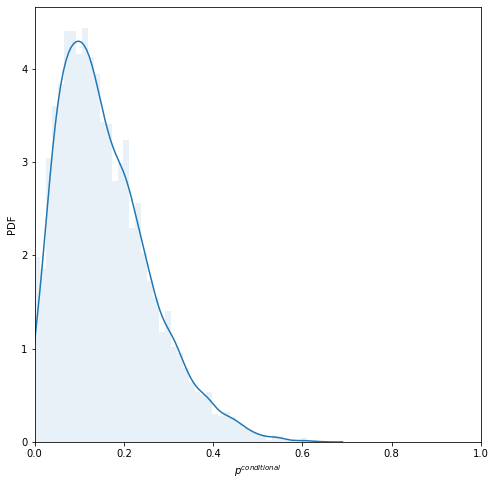

In [57]:
network_data_BC_P_shuffled = remove_correlation_run_configuration_model(network_data_BC_P, precision=10**(-5), loops=10000)

100%|██████████| 1507/1507 [00:03<00:00, 499.78it/s]


Number of zero positive degree  15
Mean positive degree  4.2786994027869945
Std positive degree  1.994509093346925
%%%%%%%
Mean negative degree  22.224286662242868
Std negative degree  4.629912775420713
%%%%%%%
Mean degree  26.502986065029862
Std degree  5.0238143271127


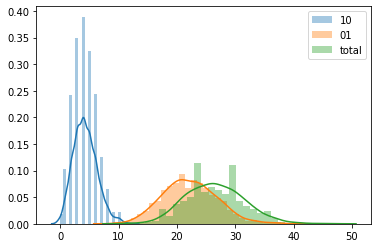

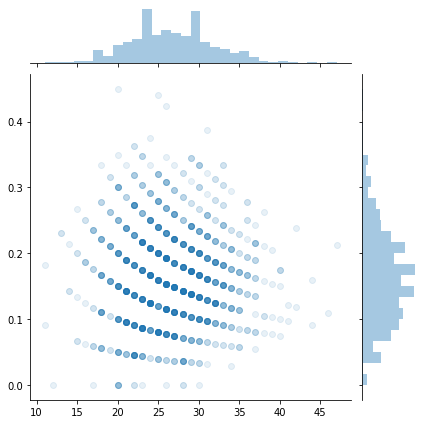

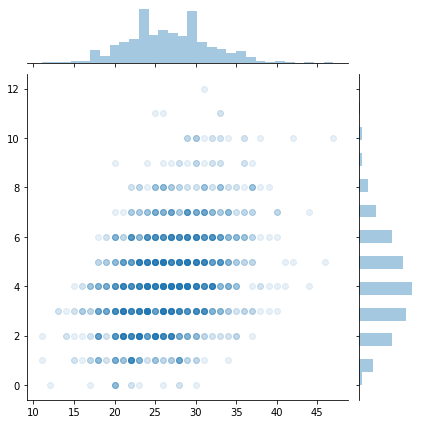

In [67]:
train, test = train_test_split(network_data_BC_P_shuffled, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              #color="#4CB391",
              alpha=0.1)



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              #color="#4CB391",
              alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

100%|██████████| 38/38 [00:00<00:00, 3793.13it/s]


Correlation between k and <Kd>:  SpearmanrResult(correlation=0.5461210198052303, pvalue=0.00038996108834437275)


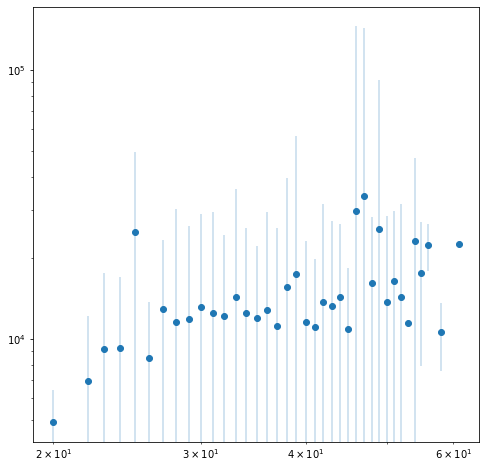

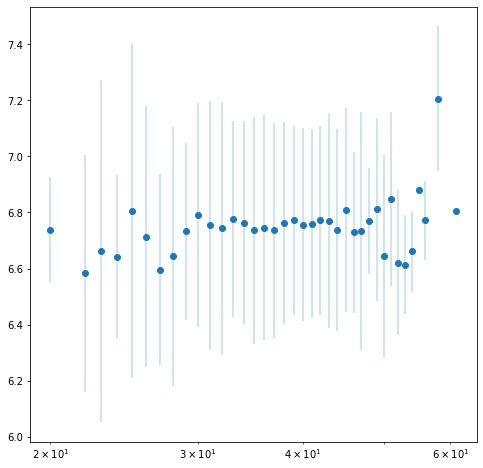

In [59]:
plot_k_Kd_relation(network_data_BC_P_shuffled)